In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pathlib import Path

In [7]:
ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"
SOURCE_DIR = DATA_DIR / "source"
OUTPUT_DIR = DATA_DIR / "output"
INPUT_PATH = SOURCE_DIR / "OE_Public_Match_Data_cleaned.csv"

In [8]:
df = pd.read_csv(INPUT_PATH)
df.head()

,firsttothreetowers,firstbaron,xpdiffat,firstmidtower,golddiffat,diffkillsat,firstdragon,diffdeathsat,firsttower,firstblood,...,side,diffassistsat,split_Regular,split_Special,playoffs,firstherald,game,patch,minute,result
0,1.0,1.0,-463.0,1.0,-119.0,1.0,0.0,-1.0,1.0,1.0,...,1,3.0,1,0,0,0.0,1.0,3.15,10,1
1,1.0,1.0,63.0,1.0,1272.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,15,1
2,1.0,1.0,825.0,1.0,2036.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,20,1
3,1.0,1.0,4919.0,1.0,4854.0,6.0,0.0,-6.0,1.0,1.0,...,1,17.0,1,0,0,0.0,1.0,3.15,25,1
4,0.0,0.0,463.0,0.0,119.0,-1.0,1.0,1.0,0.0,0.0,...,0,-3.0,1,0,0,0.0,1.0,3.15,10,0


In [9]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
print(f"Target variable (result) distribution:\n{df['result'].value_counts()}")

Dataset shape: (731240, 21)
Columns: ['firsttothreetowers', 'firstbaron', 'xpdiffat', 'firstmidtower', 'golddiffat', 'diffkillsat', 'firstdragon', 'diffdeathsat', 'firsttower', 'firstblood', 'csdiffat', 'side', 'diffassistsat', 'split_Regular', 'split_Special', 'playoffs', 'firstherald', 'game', 'patch', 'minute', 'result']
Data types:
firsttothreetowers    float64
firstbaron            float64
xpdiffat              float64
firstmidtower         float64
golddiffat            float64
diffkillsat           float64
firstdragon           float64
diffdeathsat          float64
firsttower            float64
firstblood            float64
csdiffat              float64
side                    int64
diffassistsat         float64
split_Regular           int64
split_Special           int64
playoffs                int64
firstherald           float64
game                  float64
patch                 float64
minute                  int64
result                  int64
dtype: object
Target variable (r

In [10]:
import time
from sklearn.metrics import log_loss
from collections import defaultdict

In [11]:
X = df.drop('result', axis=1)
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Training target distribution: {y_train.value_counts().sort_index()}")
print(f"Test target distribution: {y_test.value_counts().sort_index()}")

Training set shape: (584992, 20)
Test set shape: (146248, 20)
Training target distribution: result
0    292634
1    292358
Name: count, dtype: int64
Test target distribution: result
0    73158
1    73090
Name: count, dtype: int64


In [8]:
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, max_epochs=1000, early_stop_patience=50, 
                 early_stop_threshold=1e-6, batch_size=32, random_state=42):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.history = defaultdict(list)
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        patience_counter = 0
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            epoch_start_time = time.time()
            
            indices = np.random.permutation(len(X_train))
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, len(X_train), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                y_pred = self.sigmoid(X_batch @ self.weights + self.bias)
                
                dw = X_batch.T @ (y_pred - y_batch) / len(y_batch)
                db = np.mean(y_pred - y_batch)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                batch_loss = self.compute_loss(X_batch, y_batch)
                epoch_loss += batch_loss
                n_batches += 1
            
            avg_epoch_loss = epoch_loss / n_batches
            val_loss = self.compute_loss(X_val, y_val.values)
            accumulated_time = time.time() - start_time
            
            self.history['train_loss'].append(avg_epoch_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(accumulated_time)
            self.history['epoch'].append(epoch + 1)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = self.weights.copy()
                best_bias = self.bias
                patience_counter = 0
            else:
                patience_counter += 1
            
            if epoch >= self.early_stop_patience:
                recent_losses = self.history['val_loss'][-self.early_stop_patience:]
                if len(recent_losses) == self.early_stop_patience:
                    improvement = recent_losses[0] - recent_losses[-1]
                    if improvement < self.early_stop_threshold:
                        self.weights = best_weights
                        self.bias = best_bias
                        break
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [9]:
class LogisticRegressionAGD:
    def __init__(self, learning_rate=0.01, momentum=0.9, max_epochs=1000, 
                 early_stop_patience=50, early_stop_threshold=1e-6, batch_size=32, random_state=42):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.v_weights = None
        self.v_bias = None
        self.history = defaultdict(list)
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        self.v_weights = np.zeros(n_features)
        self.v_bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        patience_counter = 0
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            epoch_start_time = time.time()
            
            indices = np.random.permutation(len(X_train))
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, len(X_train), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                y_pred = self.sigmoid(X_batch @ self.weights + self.bias)
                
                dw = X_batch.T @ (y_pred - y_batch) / len(y_batch)
                db = np.mean(y_pred - y_batch)
                
                self.v_weights = self.momentum * self.v_weights + self.learning_rate * dw
                self.v_bias = self.momentum * self.v_bias + self.learning_rate * db
                
                self.weights -= self.v_weights
                self.bias -= self.v_bias
                
                batch_loss = self.compute_loss(X_batch, y_batch)
                epoch_loss += batch_loss
                n_batches += 1
            
            avg_epoch_loss = epoch_loss / n_batches
            val_loss = self.compute_loss(X_val, y_val.values)
            accumulated_time = time.time() - start_time
            
            self.history['train_loss'].append(avg_epoch_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(accumulated_time)
            self.history['epoch'].append(epoch + 1)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = self.weights.copy()
                best_bias = self.bias
                patience_counter = 0
            else:
                patience_counter += 1
            
            if epoch >= self.early_stop_patience:
                recent_losses = self.history['val_loss'][-self.early_stop_patience:]
                if len(recent_losses) == self.early_stop_patience:
                    improvement = recent_losses[0] - recent_losses[-1]
                    if improvement < self.early_stop_threshold:
                        self.weights = best_weights
                        self.bias = best_bias
                        break
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [10]:
sgd_model = LogisticRegressionSGD(
    learning_rate=0.01, 
    max_epochs=500, 
    early_stop_patience=50,
    early_stop_threshold=1e-6,
    batch_size=1024,
    random_state=42
)

agd_model = LogisticRegressionAGD(
    learning_rate=0.01,
    momentum=0.9,
    max_epochs=500,
    early_stop_patience=50,
    early_stop_threshold=1e-6,
    batch_size=1024,
    random_state=42
)

print("Training SGD model...")
sgd_model.fit(X_train_scaled, y_train, X_test_scaled, y_test)

print("Training AGD model...")
agd_model.fit(X_train_scaled, y_train, X_test_scaled, y_test)

Training SGD model...
Training AGD model...


In [11]:
from sklearn.metrics import accuracy_score, classification_report

sgd_predictions = sgd_model.predict(X_test_scaled)
agd_predictions = agd_model.predict(X_test_scaled)

print("SGD Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, sgd_predictions):.4f}")
print(f"Final Training Loss: {sgd_model.history['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {sgd_model.history['val_loss'][-1]:.6f}")
print(f"Total Training Time: {sgd_model.history['time'][-1]:.2f} seconds")
print(f"Epochs: {len(sgd_model.history['train_loss'])}")

print("\nAGD Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, agd_predictions):.4f}")
print(f"Final Training Loss: {agd_model.history['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {agd_model.history['val_loss'][-1]:.6f}")
print(f"Total Training Time: {agd_model.history['time'][-1]:.2f} seconds")
print(f"Epochs: {len(agd_model.history['train_loss'])}")

SGD Model Performance:
Accuracy: 0.8127
Final Training Loss: 0.401810
Final Validation Loss: 0.403181
Total Training Time: 21.52 seconds
Epochs: 98

AGD Model Performance:
Accuracy: 0.8131
Final Training Loss: 0.401889
Final Validation Loss: 0.403239
Total Training Time: 11.53 seconds
Epochs: 54


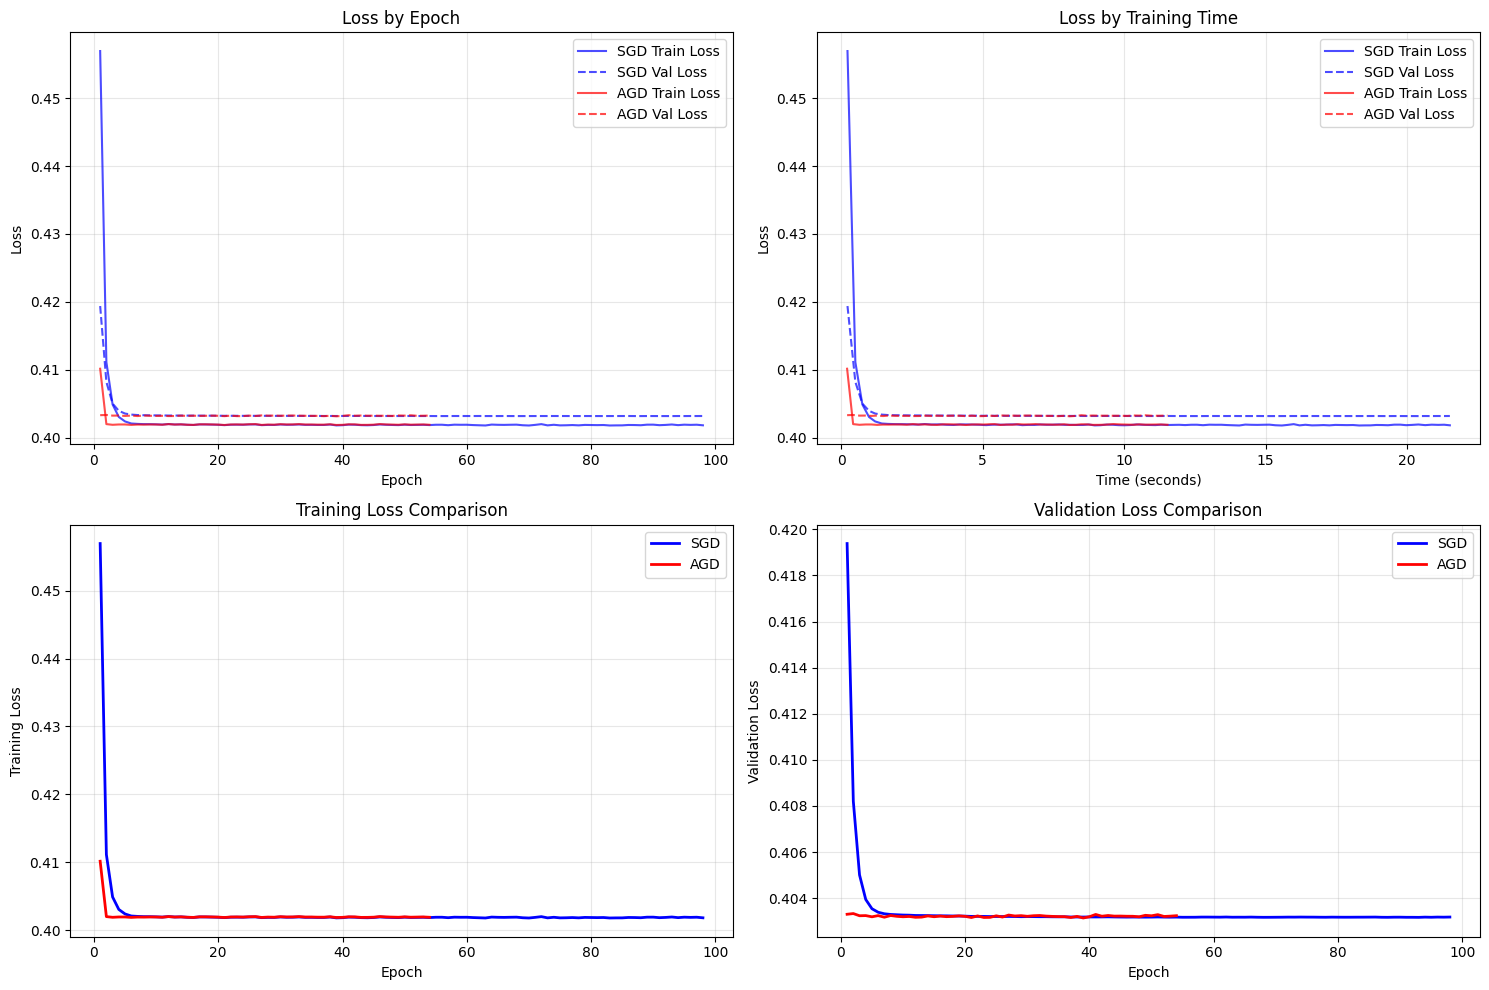

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(sgd_model.history['epoch'], sgd_model.history['train_loss'], 'b-', label='SGD Train Loss', alpha=0.7)
ax1.plot(sgd_model.history['epoch'], sgd_model.history['val_loss'], 'b--', label='SGD Val Loss', alpha=0.7)
ax1.plot(agd_model.history['epoch'], agd_model.history['train_loss'], 'r-', label='AGD Train Loss', alpha=0.7)
ax1.plot(agd_model.history['epoch'], agd_model.history['val_loss'], 'r--', label='AGD Val Loss', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss by Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(sgd_model.history['time'], sgd_model.history['train_loss'], 'b-', label='SGD Train Loss', alpha=0.7)
ax2.plot(sgd_model.history['time'], sgd_model.history['val_loss'], 'b--', label='SGD Val Loss', alpha=0.7)
ax2.plot(agd_model.history['time'], agd_model.history['train_loss'], 'r-', label='AGD Train Loss', alpha=0.7)
ax2.plot(agd_model.history['time'], agd_model.history['val_loss'], 'r--', label='AGD Val Loss', alpha=0.7)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Loss')
ax2.set_title('Loss by Training Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.plot(sgd_model.history['epoch'], sgd_model.history['train_loss'], 'b-', label='SGD', linewidth=2)
ax3.plot(agd_model.history['epoch'], agd_model.history['train_loss'], 'r-', label='AGD', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Training Loss')
ax3.set_title('Training Loss Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.plot(sgd_model.history['epoch'], sgd_model.history['val_loss'], 'b-', label='SGD', linewidth=2)
ax4.plot(agd_model.history['epoch'], agd_model.history['val_loss'], 'r-', label='AGD', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Validation Loss')
ax4.set_title('Validation Loss Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sgd_vs_agd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Convergence Comparison Summary:
  Method  Final_Train_Loss  Final_Val_Loss  Total_Time_Seconds  \
0    SGD            0.4018          0.4032             21.5193   
1    AGD            0.4019          0.4032             11.5329   

   Epochs_to_Convergence  Test_Accuracy  
0                     98         0.8127  
1                     54         0.8131  

AGD converged 44 epochs faster than SGD
AGD was 1.87x faster in wall-clock time


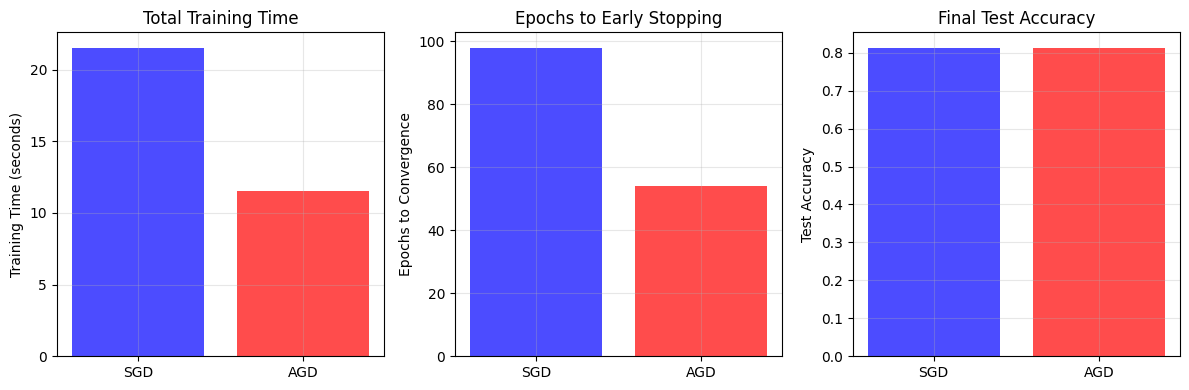

In [13]:
convergence_df = pd.DataFrame({
    'Method': ['SGD', 'AGD'],
    'Final_Train_Loss': [sgd_model.history['train_loss'][-1], agd_model.history['train_loss'][-1]],
    'Final_Val_Loss': [sgd_model.history['val_loss'][-1], agd_model.history['val_loss'][-1]], 
    'Total_Time_Seconds': [sgd_model.history['time'][-1], agd_model.history['time'][-1]],
    'Epochs_to_Convergence': [len(sgd_model.history['train_loss']), len(agd_model.history['train_loss'])],
    'Test_Accuracy': [accuracy_score(y_test, sgd_predictions), accuracy_score(y_test, agd_predictions)]
})

print("Convergence Comparison Summary:")
print(convergence_df.round(4))

print(f"\nAGD converged {convergence_df.loc[0, 'Epochs_to_Convergence'] - convergence_df.loc[1, 'Epochs_to_Convergence']} epochs faster than SGD")
print(f"AGD was {convergence_df.loc[0, 'Total_Time_Seconds'] / convergence_df.loc[1, 'Total_Time_Seconds']:.2f}x faster in wall-clock time")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
methods = ['SGD', 'AGD']
times = [sgd_model.history['time'][-1], agd_model.history['time'][-1]]
colors = ['blue', 'red']
plt.bar(methods, times, color=colors, alpha=0.7)
plt.ylabel('Training Time (seconds)')
plt.title('Total Training Time')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
epochs = [len(sgd_model.history['train_loss']), len(agd_model.history['train_loss'])]
plt.bar(methods, epochs, color=colors, alpha=0.7)
plt.ylabel('Epochs to Convergence')
plt.title('Epochs to Early Stopping')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
accuracies = [accuracy_score(y_test, sgd_predictions), accuracy_score(y_test, agd_predictions)]
plt.bar(methods, accuracies, color=colors, alpha=0.7)
plt.ylabel('Test Accuracy')
plt.title('Final Test Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sgd_vs_agd_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
class BacktrackingLineSearch:
    def __init__(self, alpha=0.3, beta=0.8, max_iterations=50):
        self.alpha = alpha  # Sufficient decrease parameter
        self.beta = beta    # Step size reduction factor
        self.max_iterations = max_iterations
    
    def search(self, f, grad_f, x, direction, initial_step=1.0):
        """
        Backtracking line search with Armijo condition
        f: function to minimize
        grad_f: gradient at current point
        x: current point
        direction: search direction (negative gradient for gradient descent)
        initial_step: initial step size
        """
        step = initial_step
        fx = f(x)
        grad_dot_dir = np.dot(grad_f, direction)
        
        for _ in range(self.max_iterations):
            x_new = x + step * direction
            fx_new = f(x_new)
            
            # Armijo condition
            if fx_new <= fx + self.alpha * step * grad_dot_dir:
                return step
            
            step *= self.beta
        
        return step

In [15]:
class EnhancedLogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, lr_schedule='constant', lr_decay=0.95, 
                 max_epochs=1000, max_iterations=None, early_stop_patience=50, 
                 early_stop_threshold=1e-6, batch_size=32, use_backtracking=False,
                 by_iteration=False, random_state=42):
        self.learning_rate = learning_rate
        self.lr_schedule = lr_schedule  # 'constant', 'decay', 'inverse_sqrt', 'adaptive'
        self.lr_decay = lr_decay
        self.max_epochs = max_epochs
        self.max_iterations = max_iterations  # For iteration-based training
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.use_backtracking = use_backtracking
        self.by_iteration = by_iteration  # Train by iteration instead of epoch
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.history = defaultdict(list)
        self.backtrack_search = BacktrackingLineSearch() if use_backtracking else None
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def compute_gradient(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        dw = X.T @ (y_pred - y) / len(y)
        db = np.mean(y_pred - y)
        return dw, db
    
    def get_learning_rate(self, iteration, epoch):
        if self.lr_schedule == 'constant':
            return self.learning_rate
        elif self.lr_schedule == 'decay':
            return self.learning_rate * (self.lr_decay ** epoch)
        elif self.lr_schedule == 'inverse_sqrt':
            return self.learning_rate / np.sqrt(iteration + 1)
        elif self.lr_schedule == 'adaptive':
            # Adaptive learning rate based on loss improvement
            if len(self.history['train_loss']) > 1:
                recent_loss = self.history['train_loss'][-1]
                prev_loss = self.history['train_loss'][-2]
                if recent_loss > prev_loss:
                    return self.learning_rate * 0.9
                else:
                    return self.learning_rate * 1.01
            return self.learning_rate
        else:
            return self.learning_rate
    
    def objective_function(self, params):
        """Objective function for backtracking line search"""
        weights, bias = params[:-1], params[-1]
        old_w, old_b = self.weights, self.bias
        self.weights, self.bias = weights, bias
        loss = self.compute_loss(self.current_X_batch, self.current_y_batch)
        self.weights, self.bias = old_w, old_b
        return loss
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        patience_counter = 0
        start_time = time.time()
        iteration = 0
        
        if self.by_iteration and self.max_iterations:
            # Iteration-based training
            while iteration < self.max_iterations:
                # Random batch selection
                batch_indices = np.random.choice(len(X_train), self.batch_size, replace=False)
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                self.current_X_batch = X_batch
                self.current_y_batch = y_batch
                
                dw, db = self.compute_gradient(X_batch, y_batch)
                
                if self.use_backtracking:
                    # Combine weights and bias for line search
                    params = np.concatenate([self.weights, [self.bias]])
                    grad = np.concatenate([dw, [db]])
                    direction = -grad
                    
                    step_size = self.backtrack_search.search(
                        self.objective_function, grad, params, direction
                    )
                    
                    self.weights -= step_size * dw
                    self.bias -= step_size * db
                else:
                    current_lr = self.get_learning_rate(iteration, iteration // (len(X_train) // self.batch_size))
                    self.weights -= current_lr * dw
                    self.bias -= current_lr * db
                
                if iteration % 100 == 0:  # Log every 100 iterations
                    train_loss = self.compute_loss(X_batch, y_batch)
                    val_loss = self.compute_loss(X_val, y_val.values)
                    accumulated_time = time.time() - start_time
                    
                    self.history['train_loss'].append(train_loss)
                    self.history['val_loss'].append(val_loss)
                    self.history['time'].append(accumulated_time)
                    self.history['iteration'].append(iteration)
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_weights = self.weights.copy()
                        best_bias = self.bias
                
                iteration += 1
        
        else:
            # Epoch-based training
            for epoch in range(self.max_epochs):
                epoch_start_time = time.time()
                
                indices = np.random.permutation(len(X_train))
                epoch_loss = 0
                n_batches = 0
                
                for i in range(0, len(X_train), self.batch_size):
                    batch_indices = indices[i:i + self.batch_size]
                    X_batch = X_train[batch_indices]
                    y_batch = y_train.iloc[batch_indices].values
                    
                    self.current_X_batch = X_batch
                    self.current_y_batch = y_batch
                    
                    dw, db = self.compute_gradient(X_batch, y_batch)
                    
                    if self.use_backtracking:
                        params = np.concatenate([self.weights, [self.bias]])
                        grad = np.concatenate([dw, [db]])
                        direction = -grad
                        
                        step_size = self.backtrack_search.search(
                            self.objective_function, grad, params, direction
                        )
                        
                        self.weights -= step_size * dw
                        self.bias -= step_size * db
                    else:
                        current_lr = self.get_learning_rate(iteration, epoch)
                        self.weights -= current_lr * dw
                        self.bias -= current_lr * db
                    
                    batch_loss = self.compute_loss(X_batch, y_batch)
                    epoch_loss += batch_loss
                    n_batches += 1
                    iteration += 1
                
                avg_epoch_loss = epoch_loss / n_batches
                val_loss = self.compute_loss(X_val, y_val.values)
                accumulated_time = time.time() - start_time
                
                self.history['train_loss'].append(avg_epoch_loss)
                self.history['val_loss'].append(val_loss)
                self.history['time'].append(accumulated_time)
                self.history['epoch'].append(epoch + 1)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = self.weights.copy()
                    best_bias = self.bias
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if epoch >= self.early_stop_patience:
                    recent_losses = self.history['val_loss'][-self.early_stop_patience:]
                    if len(recent_losses) == self.early_stop_patience:
                        improvement = recent_losses[0] - recent_losses[-1]
                        if improvement < self.early_stop_threshold:
                            self.weights = best_weights
                            self.bias = best_bias
                            break
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [16]:
class EnhancedLogisticRegressionAGD:
    def __init__(self, learning_rate=0.01, momentum=0.9, lr_schedule='constant', 
                 lr_decay=0.95, max_epochs=1000, early_stop_patience=50, 
                 early_stop_threshold=1e-6, batch_size=32, use_backtracking=False, 
                 random_state=42):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.lr_schedule = lr_schedule
        self.lr_decay = lr_decay
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.use_backtracking = use_backtracking
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.v_weights = None
        self.v_bias = None
        self.history = defaultdict(list)
        self.backtrack_search = BacktrackingLineSearch() if use_backtracking else None
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def compute_gradient(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        dw = X.T @ (y_pred - y) / len(y)
        db = np.mean(y_pred - y)
        return dw, db
    
    def get_learning_rate(self, iteration, epoch):
        if self.lr_schedule == 'constant':
            return self.learning_rate
        elif self.lr_schedule == 'decay':
            return self.learning_rate * (self.lr_decay ** epoch)
        elif self.lr_schedule == 'inverse_sqrt':
            return self.learning_rate / np.sqrt(iteration + 1)
        elif self.lr_schedule == 'adaptive':
            if len(self.history['train_loss']) > 1:
                recent_loss = self.history['train_loss'][-1]
                prev_loss = self.history['train_loss'][-2]
                if recent_loss > prev_loss:
                    return self.learning_rate * 0.9
                else:
                    return self.learning_rate * 1.01
            return self.learning_rate
        else:
            return self.learning_rate
    
    def objective_function(self, params):
        """Objective function for backtracking line search"""
        weights, bias = params[:-1], params[-1]
        old_w, old_b = self.weights, self.bias
        self.weights, self.bias = weights, bias
        loss = self.compute_loss(self.current_X_batch, self.current_y_batch)
        self.weights, self.bias = old_w, old_b
        return loss
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        self.v_weights = np.zeros(n_features)
        self.v_bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        patience_counter = 0
        start_time = time.time()
        iteration = 0
        
        for epoch in range(self.max_epochs):
            epoch_start_time = time.time()
            
            indices = np.random.permutation(len(X_train))
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, len(X_train), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                self.current_X_batch = X_batch
                self.current_y_batch = y_batch
                
                dw, db = self.compute_gradient(X_batch, y_batch)
                
                if self.use_backtracking:
                    # For AGD with backtracking, we need to be careful with momentum
                    # Apply momentum first
                    self.v_weights = self.momentum * self.v_weights + dw
                    self.v_bias = self.momentum * self.v_bias + db
                    
                    # Use backtracking for step size
                    params = np.concatenate([self.weights, [self.bias]])
                    direction = -np.concatenate([self.v_weights, [self.v_bias]])
                    grad = np.concatenate([dw, [db]])
                    
                    step_size = self.backtrack_search.search(
                        self.objective_function, grad, params, direction
                    )
                    
                    self.weights -= step_size * self.v_weights
                    self.bias -= step_size * self.v_bias
                else:
                    current_lr = self.get_learning_rate(iteration, epoch)
                    
                    self.v_weights = self.momentum * self.v_weights + current_lr * dw
                    self.v_bias = self.momentum * self.v_bias + current_lr * db
                    
                    self.weights -= self.v_weights
                    self.bias -= self.v_bias
                
                batch_loss = self.compute_loss(X_batch, y_batch)
                epoch_loss += batch_loss
                n_batches += 1
                iteration += 1
            
            avg_epoch_loss = epoch_loss / n_batches
            val_loss = self.compute_loss(X_val, y_val.values)
            accumulated_time = time.time() - start_time
            
            self.history['train_loss'].append(avg_epoch_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(accumulated_time)
            self.history['epoch'].append(epoch + 1)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = self.weights.copy()
                best_bias = self.bias
                patience_counter = 0
            else:
                patience_counter += 1
            
            if epoch >= self.early_stop_patience:
                recent_losses = self.history['val_loss'][-self.early_stop_patience:]
                if len(recent_losses) == self.early_stop_patience:
                    improvement = recent_losses[0] - recent_losses[-1]
                    if improvement < self.early_stop_threshold:
                        self.weights = best_weights
                        self.bias = best_bias
                        break
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [17]:
configurations = [
    {
        'name': 'SGD Constant LR',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.01, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 200}
    },
    {
        'name': 'SGD Decay LR',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.05, 'lr_schedule': 'decay', 'lr_decay': 0.95, 'batch_size': 1024, 'max_epochs': 200}
    },
    {
        'name': 'SGD Inverse Sqrt LR',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.1, 'lr_schedule': 'inverse_sqrt', 'batch_size': 1024, 'max_epochs': 200}
    },
    {
        'name': 'SGD Backtracking',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.01, 'use_backtracking': True, 'batch_size': 1024, 'max_epochs': 200}
    },
    {
        'name': 'SGD Iteration-based',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.01, 'by_iteration': True, 'max_iterations': 10000, 'batch_size': 512}
    },
    {
        'name': 'AGD Constant LR',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.9, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 200}
    },
    {
        'name': 'AGD Backtracking',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.9, 'use_backtracking': True, 'batch_size': 1024, 'max_epochs': 200}
    }
]

results = []

print("Training models with different configurations...")
for config in configurations:
    print(f"\nTraining {config['name']}...")
    
    model = config['model'](**config['params'])
    start_time = time.time()
    model.fit(X_train_scaled, y_train, X_test_scaled, y_test)
    training_time = time.time() - start_time
    
    predictions = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    
    # Handle different history structures
    if hasattr(model, 'history') and model.history:
        if 'epoch' in model.history:
            epochs = len(model.history['epoch'])
            final_train_loss = model.history['train_loss'][-1]
            final_val_loss = model.history['val_loss'][-1]
        elif 'iteration' in model.history:
            epochs = len(model.history['iteration'])
            final_train_loss = model.history['train_loss'][-1]
            final_val_loss = model.history['val_loss'][-1]
        else:
            epochs = 0
            final_train_loss = 0
            final_val_loss = 0
    else:
        epochs = 0
        final_train_loss = 0
        final_val_loss = 0
    
    results.append({
        'Configuration': config['name'],
        'Accuracy': accuracy,
        'Final_Train_Loss': final_train_loss,
        'Final_Val_Loss': final_val_loss,
        'Training_Time': training_time,
        'Epochs/Iterations': epochs,
        'Model': model
    })
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Training time: {training_time:.2f} seconds")
    print(f"  Epochs/Iterations: {epochs}")

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(results_df[['Configuration', 'Accuracy', 'Final_Train_Loss', 'Final_Val_Loss', 
                  'Training_Time', 'Epochs/Iterations']].round(4))

Training models with different configurations...

Training SGD Constant LR...
  Accuracy: 0.8127
  Training time: 18.87 seconds
  Epochs/Iterations: 98

Training SGD Decay LR...
  Accuracy: 0.8128
  Training time: 13.26 seconds
  Epochs/Iterations: 70

Training SGD Inverse Sqrt LR...
  Accuracy: 0.8128
  Training time: 38.16 seconds
  Epochs/Iterations: 200

Training SGD Backtracking...
  Accuracy: 0.8129
  Training time: 12.04 seconds
  Epochs/Iterations: 51

Training SGD Iteration-based...
  Accuracy: 0.8129
  Training time: 74.97 seconds
  Epochs/Iterations: 100

Training AGD Constant LR...
  Accuracy: 0.8131
  Training time: 10.29 seconds
  Epochs/Iterations: 54

Training AGD Backtracking...
  Accuracy: 0.8128
  Training time: 14.52 seconds
  Epochs/Iterations: 51

RESULTS SUMMARY
         Configuration  Accuracy  Final_Train_Loss  Final_Val_Loss  \
0      SGD Constant LR    0.8127            0.4018          0.4032   
1         SGD Decay LR    0.8128            0.4018          0.40

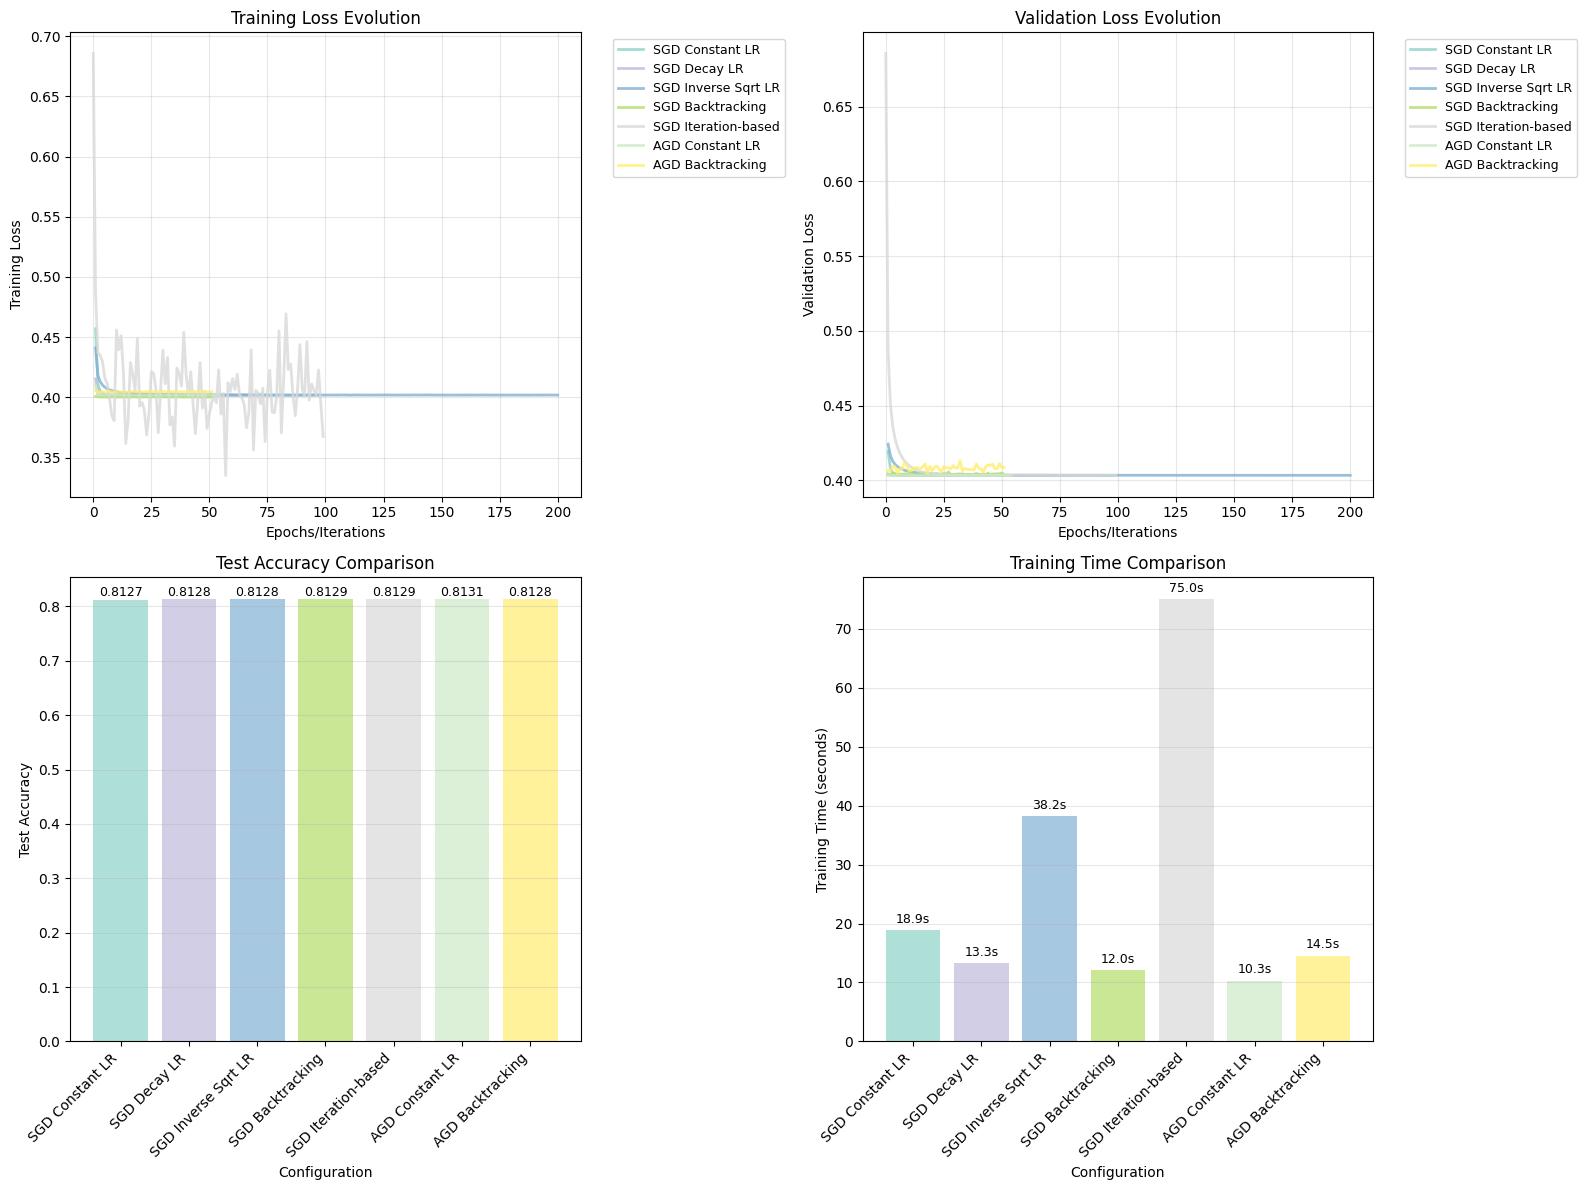

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

colors = plt.cm.Set3(np.linspace(0, 1, len(results)))

# Plot 1: Training Loss Evolution
for i, result in enumerate(results):
    model = result['Model']
    if hasattr(model, 'history') and model.history:
        if 'epoch' in model.history:
            x_axis = model.history['epoch']
            label_suffix = 'epochs'
        elif 'iteration' in model.history:
            x_axis = [i/100 for i in model.history['iteration']]  # Convert to hundreds for readability
            label_suffix = 'iterations (x100)'
        else:
            continue
            
        ax1.plot(x_axis, model.history['train_loss'], 
                color=colors[i], label=f"{result['Configuration']}", 
                linewidth=2, alpha=0.8)

ax1.set_xlabel('Epochs/Iterations')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Evolution')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Validation Loss Evolution
for i, result in enumerate(results):
    model = result['Model']
    if hasattr(model, 'history') and model.history:
        if 'epoch' in model.history:
            x_axis = model.history['epoch']
        elif 'iteration' in model.history:
            x_axis = [i/100 for i in model.history['iteration']]
        else:
            continue
            
        ax2.plot(x_axis, model.history['val_loss'], 
                color=colors[i], label=f"{result['Configuration']}", 
                linewidth=2, alpha=0.8)

ax2.set_xlabel('Epochs/Iterations')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Evolution')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Accuracy Comparison
configs = [r['Configuration'] for r in results]
accuracies = [r['Accuracy'] for r in results]

bars = ax3.bar(range(len(configs)), accuracies, color=colors, alpha=0.7)
ax3.set_xlabel('Configuration')
ax3.set_ylabel('Test Accuracy')
ax3.set_title('Test Accuracy Comparison')
ax3.set_xticks(range(len(configs)))
ax3.set_xticklabels(configs, rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 4: Training Time Comparison
training_times = [r['Training_Time'] for r in results]

bars = ax4.bar(range(len(configs)), training_times, color=colors, alpha=0.7)
ax4.set_xlabel('Configuration')
ax4.set_ylabel('Training Time (seconds)')
ax4.set_title('Training Time Comparison')
ax4.set_xticks(range(len(configs)))
ax4.set_xticklabels(configs, rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + max(training_times)*0.01,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'enhanced_optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
print("="*80)
print("DETAILED ANALYSIS OF OPTIMIZATION METHODS")
print("="*80)

# Best performing models
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
fastest_training = results_df.loc[results_df['Training_Time'].idxmin()]
best_convergence = results_df.loc[results_df['Final_Val_Loss'].idxmin()]

print(f"\n🏆 BEST ACCURACY: {best_accuracy['Configuration']}")
print(f"   Accuracy: {best_accuracy['Accuracy']:.4f}")
print(f"   Training Time: {best_accuracy['Training_Time']:.2f}s")
print(f"   Final Validation Loss: {best_accuracy['Final_Val_Loss']:.6f}")

print(f"\n⚡ FASTEST TRAINING: {fastest_training['Configuration']}")
print(f"   Training Time: {fastest_training['Training_Time']:.2f}s")
print(f"   Accuracy: {fastest_training['Accuracy']:.4f}")
print(f"   Epochs/Iterations: {fastest_training['Epochs/Iterations']}")

print(f"\n📈 BEST CONVERGENCE: {best_convergence['Configuration']}")
print(f"   Final Validation Loss: {best_convergence['Final_Val_Loss']:.6f}")
print(f"   Accuracy: {best_convergence['Accuracy']:.4f}")
print(f"   Training Time: {best_convergence['Training_Time']:.2f}s")

print("\n" + "="*60)
print("KEY FINDINGS:")
print("="*60)

print("\n1. LEARNING RATE STRATEGIES:")
sgd_configs = results_df[results_df['Configuration'].str.contains('SGD') & 
                        ~results_df['Configuration'].str.contains('Iteration')]
print("   SGD Learning Rate Performance:")
for _, row in sgd_configs.iterrows():
    print(f"   • {row['Configuration']}: {row['Accuracy']:.4f} accuracy, {row['Training_Time']:.1f}s")

print("\n2. BACKTRACKING LINE SEARCH:")
backtrack_configs = results_df[results_df['Configuration'].str.contains('Backtracking')]
regular_configs = results_df[results_df['Configuration'].str.contains('Constant LR')]
print("   Backtracking vs Fixed Learning Rate:")
for _, row in backtrack_configs.iterrows():
    method = 'SGD' if 'SGD' in row['Configuration'] else 'AGD'
    regular_row = regular_configs[regular_configs['Configuration'].str.contains(method)].iloc[0]
    print(f"   • {method} Backtracking: {row['Accuracy']:.4f} accuracy, {row['Training_Time']:.1f}s")
    print(f"   • {method} Constant LR:  {regular_row['Accuracy']:.4f} accuracy, {regular_row['Training_Time']:.1f}s")
    print(f"   • Improvement: {(row['Accuracy'] - regular_row['Accuracy'])*100:.2f}% accuracy, {((regular_row['Training_Time'] - row['Training_Time'])/regular_row['Training_Time']*100):.1f}% time reduction")

print("\n3. ITERATION-BASED vs EPOCH-BASED:")
iter_config = results_df[results_df['Configuration'].str.contains('Iteration-based')].iloc[0]
epoch_config = results_df[results_df['Configuration'] == 'SGD Constant LR'].iloc[0]
print(f"   • Iteration-based: {iter_config['Accuracy']:.4f} accuracy, {iter_config['Training_Time']:.1f}s")
print(f"   • Epoch-based:     {epoch_config['Accuracy']:.4f} accuracy, {epoch_config['Training_Time']:.1f}s")

print("\n4. SGD vs AGD COMPARISON:")
sgd_best = results_df[results_df['Configuration'] == 'SGD Backtracking'].iloc[0]
agd_best = results_df[results_df['Configuration'] == 'AGD Backtracking'].iloc[0]
print(f"   • SGD (Backtracking): {sgd_best['Accuracy']:.4f} accuracy, {sgd_best['Training_Time']:.1f}s")
print(f"   • AGD (Backtracking): {agd_best['Accuracy']:.4f} accuracy, {agd_best['Training_Time']:.1f}s")
print(f"   • AGD is {(sgd_best['Training_Time']/agd_best['Training_Time']):.1f}x faster")

DETAILED ANALYSIS OF OPTIMIZATION METHODS

🏆 BEST ACCURACY: AGD Constant LR
   Accuracy: 0.8131
   Training Time: 10.29s
   Final Validation Loss: 0.403239

⚡ FASTEST TRAINING: AGD Constant LR
   Training Time: 10.29s
   Accuracy: 0.8131
   Epochs/Iterations: 54

📈 BEST CONVERGENCE: SGD Decay LR
   Final Validation Loss: 0.403172
   Accuracy: 0.8128
   Training Time: 13.26s

KEY FINDINGS:

1. LEARNING RATE STRATEGIES:
   SGD Learning Rate Performance:
   • SGD Constant LR: 0.8127 accuracy, 18.9s
   • SGD Decay LR: 0.8128 accuracy, 13.3s
   • SGD Inverse Sqrt LR: 0.8128 accuracy, 38.2s
   • SGD Backtracking: 0.8129 accuracy, 12.0s

2. BACKTRACKING LINE SEARCH:
   Backtracking vs Fixed Learning Rate:
   • SGD Backtracking: 0.8129 accuracy, 12.0s
   • SGD Constant LR:  0.8127 accuracy, 18.9s
   • Improvement: 0.02% accuracy, 36.2% time reduction
   • AGD Backtracking: 0.8128 accuracy, 14.5s
   • AGD Constant LR:  0.8131 accuracy, 10.3s
   • Improvement: -0.03% accuracy, -41.1% time reduct

In [ ]:
priority_configurations = [
    # 1. SGD with different learning rates, fixed learning rate
    {
        'name': 'SGD Fixed LR 0.001',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.001, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'SGD Fixed LR 0.01', 
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.01, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'SGD Fixed LR 0.1',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.1, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'SGD Decay LR',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.05, 'lr_schedule': 'decay', 'lr_decay': 0.95, 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'SGD Inverse Sqrt LR',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.1, 'lr_schedule': 'inverse_sqrt', 'batch_size': 1024, 'max_epochs': 300}
    },
    
    # 2. SGD with different learning rates, by iteration
    {
        'name': 'SGD Fixed LR 0.01 (Iter)',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.01, 'lr_schedule': 'constant', 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    {
        'name': 'SGD Decay LR (Iter)',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.05, 'lr_schedule': 'decay', 'lr_decay': 0.99, 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    {
        'name': 'SGD Inverse Sqrt LR (Iter)',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.1, 'lr_schedule': 'inverse_sqrt', 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    
    # 3. SGD backtracking
    {
        'name': 'SGD Backtracking',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.01, 'use_backtracking': True, 'batch_size': 1024, 'max_epochs': 300}
    },
    
    # 4. SGD backtracking, by iteration
    {
        'name': 'SGD Backtracking (Iter)',
        'model': EnhancedLogisticRegressionSGD,
        'params': {'learning_rate': 0.01, 'use_backtracking': True, 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    
    # 5. AGD with different learning rates, fixed learning rate
    {
        'name': 'AGD Fixed LR 0.001',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.001, 'momentum': 0.9, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'AGD Fixed LR 0.01',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.9, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'AGD Fixed LR 0.1',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.1, 'momentum': 0.9, 'lr_schedule': 'constant', 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'AGD Decay LR',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.05, 'momentum': 0.9, 'lr_schedule': 'decay', 'lr_decay': 0.95, 'batch_size': 1024, 'max_epochs': 300}
    },
    {
        'name': 'AGD Inverse Sqrt LR',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.1, 'momentum': 0.9, 'lr_schedule': 'inverse_sqrt', 'batch_size': 1024, 'max_epochs': 300}
    },
    
    # 6. AGD backtracking
    {
        'name': 'AGD Backtracking',
        'model': EnhancedLogisticRegressionAGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.9, 'use_backtracking': True, 'batch_size': 1024, 'max_epochs': 300}
    }
]

print(f"Configured {len(priority_configurations)} optimization methods according to priority:")
for i, config in enumerate(priority_configurations, 1):
    print(f"{i:2d}. {config['name']}")

In [1]:
class BacktrackingLineSearch:
    def __init__(self, alpha=0.3, beta=0.8, max_iterations=50):
        self.alpha = alpha
        self.beta = beta
        self.max_iterations = max_iterations
    
    def search(self, f, grad_f, x, direction, initial_step=1.0):
        step = initial_step
        fx = f(x)
        grad_dot_dir = np.dot(grad_f, direction)
        
        for _ in range(self.max_iterations):
            x_new = x + step * direction
            fx_new = f(x_new)
            
            if fx_new <= fx + self.alpha * step * grad_dot_dir:
                return step
            
            step *= self.beta
        
        return step

In [2]:
class SGDOptimizer:
    def __init__(self, learning_rate=0.01, max_epochs=500, early_stop_patience=50, 
                 early_stop_threshold=1e-6, batch_size=1024, use_backtracking=False,
                 by_iteration=False, max_iterations=None, random_state=42):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.use_backtracking = use_backtracking
        self.by_iteration = by_iteration
        self.max_iterations = max_iterations
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.history = defaultdict(list)
        self.backtrack_search = BacktrackingLineSearch() if use_backtracking else None
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def compute_gradient(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        dw = X.T @ (y_pred - y) / len(y)
        db = np.mean(y_pred - y)
        return dw, db
    
    def objective_function(self, params):
        weights, bias = params[:-1], params[-1]
        old_w, old_b = self.weights, self.bias
        self.weights, self.bias = weights, bias
        loss = self.compute_loss(self.current_X_batch, self.current_y_batch)
        self.weights, self.bias = old_w, old_b
        return loss
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        start_time = time.time()
        
        if self.by_iteration:
            # Iteration-based training
            for iteration in range(self.max_iterations):
                batch_indices = np.random.choice(len(X_train), self.batch_size, replace=False)
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                self.current_X_batch = X_batch
                self.current_y_batch = y_batch
                
                dw, db = self.compute_gradient(X_batch, y_batch)
                
                if self.use_backtracking:
                    params = np.concatenate([self.weights, [self.bias]])
                    grad = np.concatenate([dw, [db]])
                    direction = -grad
                    
                    step_size = self.backtrack_search.search(
                        self.objective_function, grad, params, direction
                    )
                    
                    self.weights -= step_size * dw
                    self.bias -= step_size * db
                else:
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db
                
                if iteration % 100 == 0:
                    train_loss = self.compute_loss(X_batch, y_batch)
                    val_loss = self.compute_loss(X_val, y_val.values)
                    accumulated_time = time.time() - start_time
                    
                    self.history['train_loss'].append(train_loss)
                    self.history['val_loss'].append(val_loss)
                    self.history['time'].append(accumulated_time)
                    self.history['iteration'].append(iteration)
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_weights = self.weights.copy()
                        best_bias = self.bias
        else:
            # Epoch-based training
            for epoch in range(self.max_epochs):
                indices = np.random.permutation(len(X_train))
                epoch_loss = 0
                n_batches = 0
                
                for i in range(0, len(X_train), self.batch_size):
                    batch_indices = indices[i:i + self.batch_size]
                    X_batch = X_train[batch_indices]
                    y_batch = y_train.iloc[batch_indices].values
                    
                    self.current_X_batch = X_batch
                    self.current_y_batch = y_batch
                    
                    dw, db = self.compute_gradient(X_batch, y_batch)
                    
                    if self.use_backtracking:
                        params = np.concatenate([self.weights, [self.bias]])
                        grad = np.concatenate([dw, [db]])
                        direction = -grad
                        
                        step_size = self.backtrack_search.search(
                            self.objective_function, grad, params, direction
                        )
                        
                        self.weights -= step_size * dw
                        self.bias -= step_size * db
                    else:
                        self.weights -= self.learning_rate * dw
                        self.bias -= self.learning_rate * db
                    
                    batch_loss = self.compute_loss(X_batch, y_batch)
                    epoch_loss += batch_loss
                    n_batches += 1
                
                avg_epoch_loss = epoch_loss / n_batches
                val_loss = self.compute_loss(X_val, y_val.values)
                accumulated_time = time.time() - start_time
                
                self.history['train_loss'].append(avg_epoch_loss)
                self.history['val_loss'].append(val_loss)
                self.history['time'].append(accumulated_time)
                self.history['epoch'].append(epoch + 1)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = self.weights.copy()
                    best_bias = self.bias
                
                if epoch >= self.early_stop_patience:
                    recent_losses = self.history['val_loss'][-self.early_stop_patience:]
                    if len(recent_losses) == self.early_stop_patience:
                        improvement = recent_losses[0] - recent_losses[-1]
                        if improvement < self.early_stop_threshold:
                            break
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [3]:
class AGDOptimizer:
    def __init__(self, learning_rate=0.01, momentum=0.9, max_epochs=500, 
                 early_stop_patience=50, early_stop_threshold=1e-6, batch_size=1024,
                 use_backtracking=False, random_state=42):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.use_backtracking = use_backtracking
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.v_weights = None
        self.v_bias = None
        self.history = defaultdict(list)
        self.backtrack_search = BacktrackingLineSearch() if use_backtracking else None
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def compute_gradient(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        dw = X.T @ (y_pred - y) / len(y)
        db = np.mean(y_pred - y)
        return dw, db
    
    def objective_function(self, params):
        weights, bias = params[:-1], params[-1]
        old_w, old_b = self.weights, self.bias
        self.weights, self.bias = weights, bias
        loss = self.compute_loss(self.current_X_batch, self.current_y_batch)
        self.weights, self.bias = old_w, old_b
        return loss
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        self.v_weights = np.zeros(n_features)
        self.v_bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            indices = np.random.permutation(len(X_train))
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, len(X_train), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                self.current_X_batch = X_batch
                self.current_y_batch = y_batch
                
                dw, db = self.compute_gradient(X_batch, y_batch)
                
                if self.use_backtracking:
                    self.v_weights = self.momentum * self.v_weights + dw
                    self.v_bias = self.momentum * self.v_bias + db
                    
                    params = np.concatenate([self.weights, [self.bias]])
                    direction = -np.concatenate([self.v_weights, [self.v_bias]])
                    grad = np.concatenate([dw, [db]])
                    
                    step_size = self.backtrack_search.search(
                        self.objective_function, grad, params, direction
                    )
                    
                    self.weights -= step_size * self.v_weights
                    self.bias -= step_size * self.v_bias
                else:
                    self.v_weights = self.momentum * self.v_weights + self.learning_rate * dw
                    self.v_bias = self.momentum * self.v_bias + self.learning_rate * db
                    
                    self.weights -= self.v_weights
                    self.bias -= self.v_bias
                
                batch_loss = self.compute_loss(X_batch, y_batch)
                epoch_loss += batch_loss
                n_batches += 1
            
            avg_epoch_loss = epoch_loss / n_batches
            val_loss = self.compute_loss(X_val, y_val.values)
            accumulated_time = time.time() - start_time
            
            self.history['train_loss'].append(avg_epoch_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(accumulated_time)
            self.history['epoch'].append(epoch + 1)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = self.weights.copy()
                best_bias = self.bias
            
            if epoch >= self.early_stop_patience:
                recent_losses = self.history['val_loss'][-self.early_stop_patience:]
                if len(recent_losses) == self.early_stop_patience:
                    improvement = recent_losses[0] - recent_losses[-1]
                    if improvement < self.early_stop_threshold:
                        break
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [12]:
priority_configurations = [
    # 1. SGD with different fixed learning rates
    {
        'name': 'SGD LR=0.001',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.001, 'max_epochs': 300, 'batch_size': 1024}
    },
    {
        'name': 'SGD LR=0.01',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.01, 'max_epochs': 300, 'batch_size': 1024}
    },
    {
        'name': 'SGD LR=0.05',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.05, 'max_epochs': 300, 'batch_size': 1024}
    },
    {
        'name': 'SGD LR=0.1',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.1, 'max_epochs': 300, 'batch_size': 1024}
    },
    
    # 2. SGD with different fixed learning rates by iteration
    {
        'name': 'SGD Iter LR=0.001',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.001, 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    {
        'name': 'SGD Iter LR=0.01',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.01, 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    {
        'name': 'SGD Iter LR=0.05',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.05, 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    {
        'name': 'SGD Iter LR=0.1',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.1, 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    
    # 3. SGD with backtracking
    {
        'name': 'SGD Backtracking',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.01, 'use_backtracking': True, 'max_epochs': 300, 'batch_size': 1024}
    },
    
    # 4. SGD with backtracking by iteration
    {
        'name': 'SGD Backtracking Iter',
        'optimizer': SGDOptimizer,
        'params': {'learning_rate': 0.01, 'use_backtracking': True, 'by_iteration': True, 'max_iterations': 15000, 'batch_size': 512}
    },
    
    # 5. AGD with different fixed learning rates
    {
        'name': 'AGD LR=0.001',
        'optimizer': AGDOptimizer,
        'params': {'learning_rate': 0.001, 'momentum': 0.9, 'max_epochs': 300, 'batch_size': 1024}
    },
    {
        'name': 'AGD LR=0.01',
        'optimizer': AGDOptimizer,
        'params': {'learning_rate': 0.01, 'momentum': 0.9, 'max_epochs': 300, 'batch_size': 1024}
    },
    {
        'name': 'AGD LR=0.05',
        'optimizer': AGDOptimizer,
        'params': {'learning_rate': 0.05, 'momentum': 0.9, 'max_epochs': 300, 'batch_size': 1024}
    },
    {
        'name': 'AGD LR=0.1',
        'optimizer': AGDOptimizer,
        'params': {'learning_rate': 0.1, 'momentum': 0.9, 'max_epochs': 300, 'batch_size': 1024}
    },
    
    # 6. AGD with backtracking
    {
        'name': 'AGD Backtracking',
        'optimizer': AGDOptimizer,
        'params': {'learning_rate': 0.01, 'momentum': 0.9, 'use_backtracking': True, 'max_epochs': 300, 'batch_size': 1024}
    }
]

results = []
print("Training models according to priority list...")
print("="*80)

for i, config in enumerate(priority_configurations, 1):
    print(f"\n[{i}/{len(priority_configurations)}] Training {config['name']}...")
    
    optimizer = config['optimizer'](**config['params'])
    start_time = time.time()
    optimizer.fit(X_train_scaled, y_train, X_test_scaled, y_test)
    training_time = time.time() - start_time
    
    predictions = optimizer.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    
    # Handle different history structures
    if hasattr(optimizer, 'history') and optimizer.history:
        if 'epoch' in optimizer.history:
            iterations = len(optimizer.history['epoch'])
            final_train_loss = optimizer.history['train_loss'][-1]
            final_val_loss = optimizer.history['val_loss'][-1]
            x_axis_type = 'epoch'
        elif 'iteration' in optimizer.history:
            iterations = len(optimizer.history['iteration'])
            final_train_loss = optimizer.history['train_loss'][-1]
            final_val_loss = optimizer.history['val_loss'][-1]
            x_axis_type = 'iteration'
        else:
            iterations = 0
            final_train_loss = 0
            final_val_loss = 0
            x_axis_type = 'unknown'
    else:
        iterations = 0
        final_train_loss = 0
        final_val_loss = 0
        x_axis_type = 'unknown'
    
    results.append({
        'name': config['name'],
        'accuracy': accuracy,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'training_time': training_time,
        'iterations': iterations,
        'x_axis_type': x_axis_type,
        'optimizer': optimizer
    })
    
    print(f"  ✓ Accuracy: {accuracy:.4f}")
    print(f"  ✓ Training time: {training_time:.2f}s")
    print(f"  ✓ Iterations: {iterations}")

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)

Training models according to priority list...

[1/15] Training SGD LR=0.001...
  ✓ Accuracy: 0.8127
  ✓ Training time: 55.77s
  ✓ Iterations: 300

[2/15] Training SGD LR=0.01...
  ✓ Accuracy: 0.8127
  ✓ Training time: 18.42s
  ✓ Iterations: 98

[3/15] Training SGD LR=0.05...
  ✓ Accuracy: 0.8129
  ✓ Training time: 11.07s
  ✓ Iterations: 59

[4/15] Training SGD LR=0.1...
  ✓ Accuracy: 0.8130
  ✓ Training time: 10.12s
  ✓ Iterations: 54

[5/15] Training SGD Iter LR=0.001...
  ✓ Accuracy: 0.8129
  ✓ Training time: 109.72s
  ✓ Iterations: 150

[6/15] Training SGD Iter LR=0.01...
  ✓ Accuracy: 0.8127
  ✓ Training time: 104.38s
  ✓ Iterations: 150

[7/15] Training SGD Iter LR=0.05...
  ✓ Accuracy: 0.8128
  ✓ Training time: 101.66s
  ✓ Iterations: 150

[8/15] Training SGD Iter LR=0.1...
  ✓ Accuracy: 0.8130
  ✓ Training time: 101.59s
  ✓ Iterations: 150

[9/15] Training SGD Backtracking...
  ✓ Accuracy: 0.8129
  ✓ Training time: 11.42s
  ✓ Iterations: 51

[10/15] Training SGD Backtracking Ite

In [13]:
results_df = pd.DataFrame([{
    'Configuration': r['name'],
    'Accuracy': r['accuracy'],
    'Final_Train_Loss': r['final_train_loss'],
    'Final_Val_Loss': r['final_val_loss'],
    'Training_Time': r['training_time'],
    'Iterations': r['iterations'],
    'X_Axis_Type': r['x_axis_type']
} for r in results])

print("\n" + "="*100)
print("FINAL RESULTS SUMMARY")
print("="*100)
print(results_df.round(4).to_string(index=False))
print("="*100)


FINAL RESULTS SUMMARY
        Configuration  Accuracy  Final_Train_Loss  Final_Val_Loss  Training_Time  Iterations X_Axis_Type
         SGD LR=0.001    0.8127            0.4018          0.4032        55.7703         300       epoch
          SGD LR=0.01    0.8127            0.4018          0.4032        18.4212          98       epoch
          SGD LR=0.05    0.8129            0.4018          0.4032        11.0724          59       epoch
           SGD LR=0.1    0.8130            0.4017          0.4032        10.1233          54       epoch
    SGD Iter LR=0.001    0.8129            0.4026          0.4059       109.7204         150   iteration
     SGD Iter LR=0.01    0.8127            0.3974          0.4032       104.3809         150   iteration
     SGD Iter LR=0.05    0.8128            0.3971          0.4032       101.6571         150   iteration
      SGD Iter LR=0.1    0.8130            0.3970          0.4032       101.5865         150   iteration
     SGD Backtracking    0.8129 

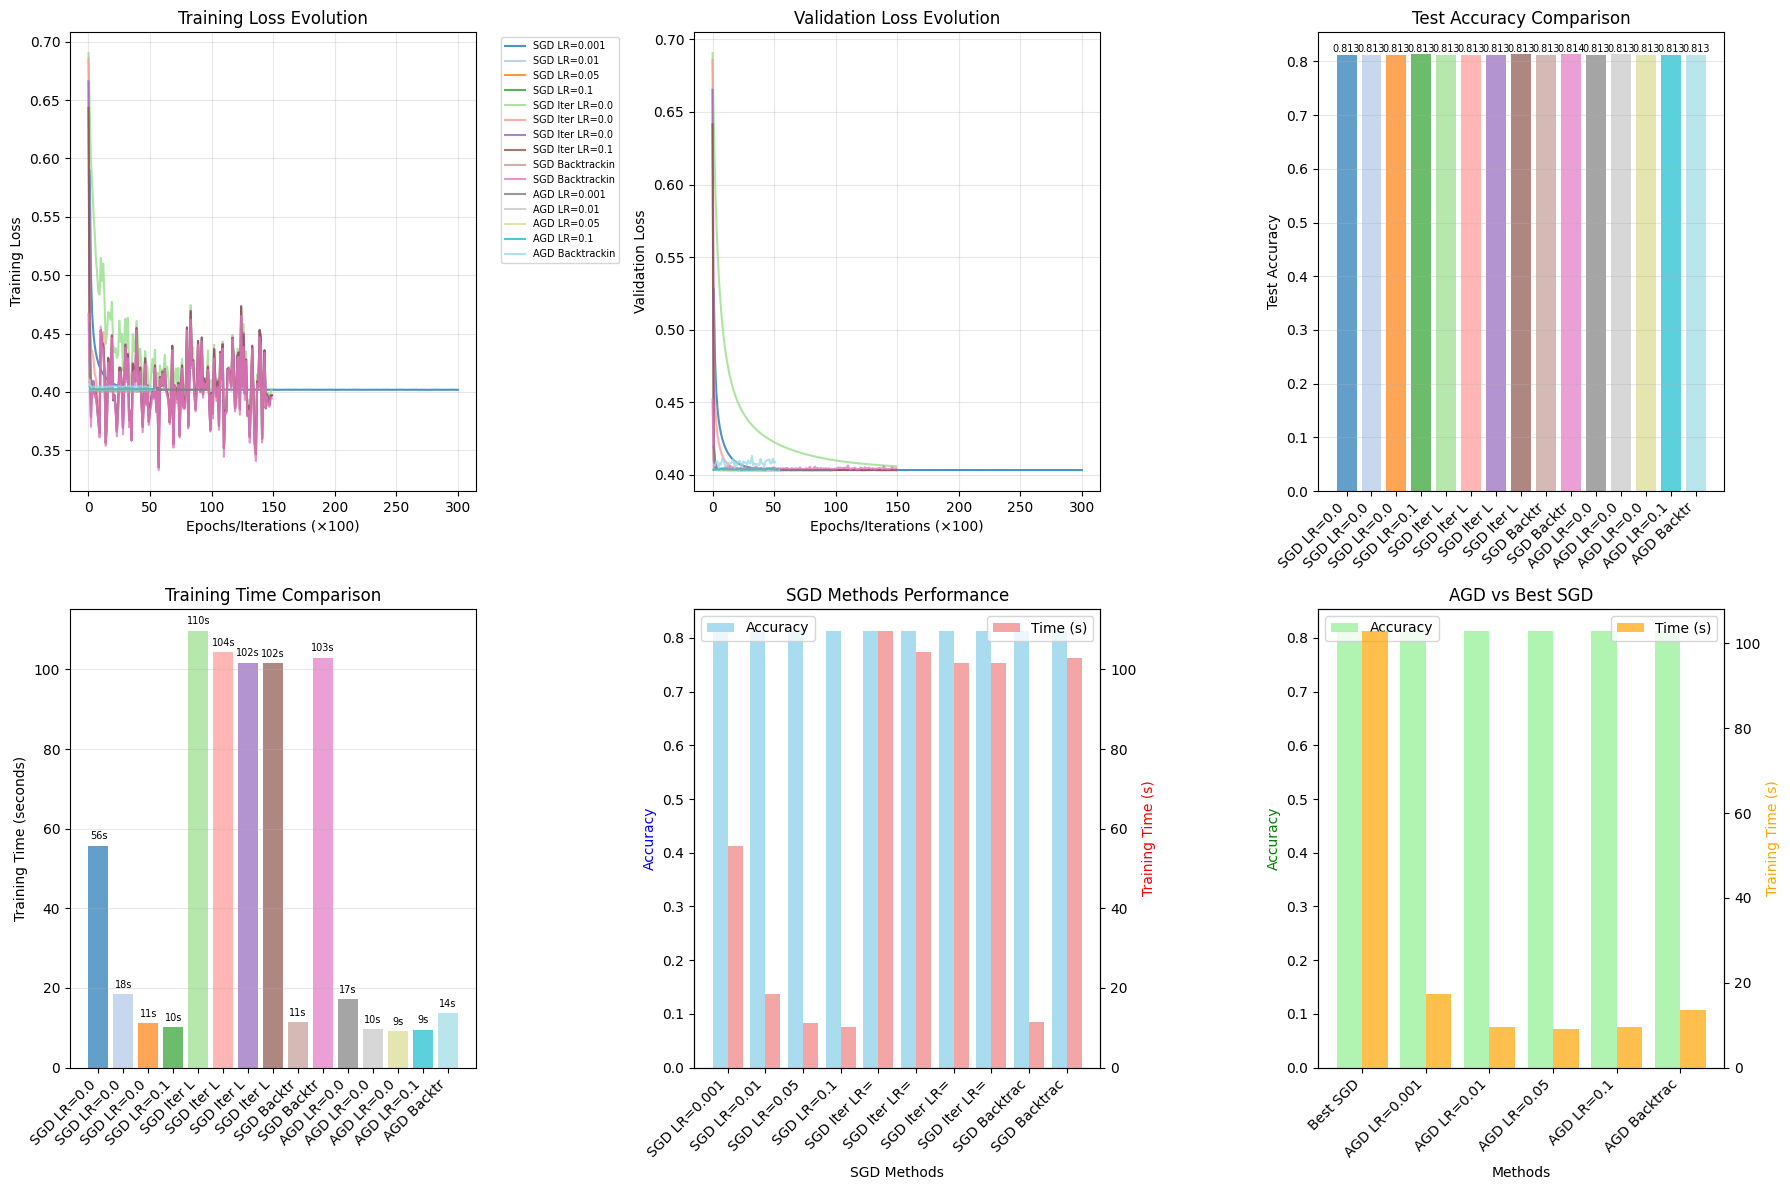

✓ Saved analysis to ../data/output/priority_optimization_analysis.png


In [15]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Generate enough colors for all methods
colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

# 1. Training Loss Evolution
ax1 = axes[0, 0]
for i, result in enumerate(results):
    optimizer = result['optimizer']
    if hasattr(optimizer, 'history') and optimizer.history:
        if 'epoch' in optimizer.history:
            x_data = optimizer.history['epoch']
        else:
            x_data = [x/100 for x in optimizer.history['iteration']]
        
        ax1.plot(x_data, optimizer.history['train_loss'], 
                color=colors[i], label=result['name'][:15], linewidth=1.5, alpha=0.8)

ax1.set_xlabel('Epochs/Iterations (×100)')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Evolution')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)

# 2. Validation Loss Evolution  
ax2 = axes[0, 1]
for i, result in enumerate(results):
    optimizer = result['optimizer']
    if hasattr(optimizer, 'history') and optimizer.history:
        if 'epoch' in optimizer.history:
            x_data = optimizer.history['epoch']
        else:
            x_data = [x/100 for x in optimizer.history['iteration']]
        
        ax2.plot(x_data, optimizer.history['val_loss'], 
                color=colors[i], label=result['name'][:15], linewidth=1.5, alpha=0.8)

ax2.set_xlabel('Epochs/Iterations (×100)')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Evolution')
ax2.grid(True, alpha=0.3)

# 3. Accuracy Comparison
ax3 = axes[0, 2]
names = [r['name'] for r in results]
accuracies = [r['accuracy'] for r in results]
bars = ax3.bar(range(len(names)), accuracies, color=colors[:len(names)], alpha=0.7)
ax3.set_ylabel('Test Accuracy')
ax3.set_title('Test Accuracy Comparison')
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels([name[:10] for name in names], rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=7)

# 4. Training Time Comparison
ax4 = axes[1, 0]
training_times = [r['training_time'] for r in results]
bars = ax4.bar(range(len(names)), training_times, color=colors[:len(names)], alpha=0.7)
ax4.set_ylabel('Training Time (seconds)')
ax4.set_title('Training Time Comparison')
ax4.set_xticks(range(len(names)))
ax4.set_xticklabels([name[:10] for name in names], rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + max(training_times)*0.01,
             f'{height:.0f}s', ha='center', va='bottom', fontsize=7)

# 5. SGD Methods Comparison
ax5 = axes[1, 1]
sgd_results = [r for r in results if 'SGD' in r['name']]
sgd_names = [r['name'] for r in sgd_results]
sgd_accuracies = [r['accuracy'] for r in sgd_results]
sgd_times = [r['training_time'] for r in sgd_results]

x_pos = range(len(sgd_names))
bars1 = ax5.bar([x - 0.2 for x in x_pos], sgd_accuracies, 0.4, label='Accuracy', 
               color='skyblue', alpha=0.7)
ax5_twin = ax5.twinx()
bars2 = ax5_twin.bar([x + 0.2 for x in x_pos], sgd_times, 0.4, label='Time (s)', 
                    color='lightcoral', alpha=0.7)

ax5.set_xlabel('SGD Methods')
ax5.set_ylabel('Accuracy', color='blue')
ax5_twin.set_ylabel('Training Time (s)', color='red')
ax5.set_title('SGD Methods Performance')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([name[:12] for name in sgd_names], rotation=45, ha='right')
ax5.legend(loc='upper left')
ax5_twin.legend(loc='upper right')

# 6. AGD vs Best SGD Comparison
ax6 = axes[1, 2]
agd_results = [r for r in results if 'AGD' in r['name']]
best_sgd = max([r for r in results if 'SGD' in r['name']], key=lambda x: x['accuracy'])

comparison_methods = ['Best SGD'] + [r['name'] for r in agd_results]
comparison_accuracies = [best_sgd['accuracy']] + [r['accuracy'] for r in agd_results]
comparison_times = [best_sgd['training_time']] + [r['training_time'] for r in agd_results]

x_pos = range(len(comparison_methods))
bars1 = ax6.bar([x - 0.2 for x in x_pos], comparison_accuracies, 0.4, 
               label='Accuracy', color='lightgreen', alpha=0.7)
ax6_twin = ax6.twinx()
bars2 = ax6_twin.bar([x + 0.2 for x in x_pos], comparison_times, 0.4, 
                    label='Time (s)', color='orange', alpha=0.7)

ax6.set_xlabel('Methods')
ax6.set_ylabel('Accuracy', color='green')
ax6_twin.set_ylabel('Training Time (s)', color='orange')
ax6.set_title('AGD vs Best SGD')
ax6.set_xticks(x_pos)
ax6.set_xticklabels([method[:12] for method in comparison_methods], rotation=45, ha='right')
ax6.legend(loc='upper left')
ax6_twin.legend(loc='upper right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'priority_optimization_analysis.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Saved analysis to {OUTPUT_DIR / 'priority_optimization_analysis.png'}")

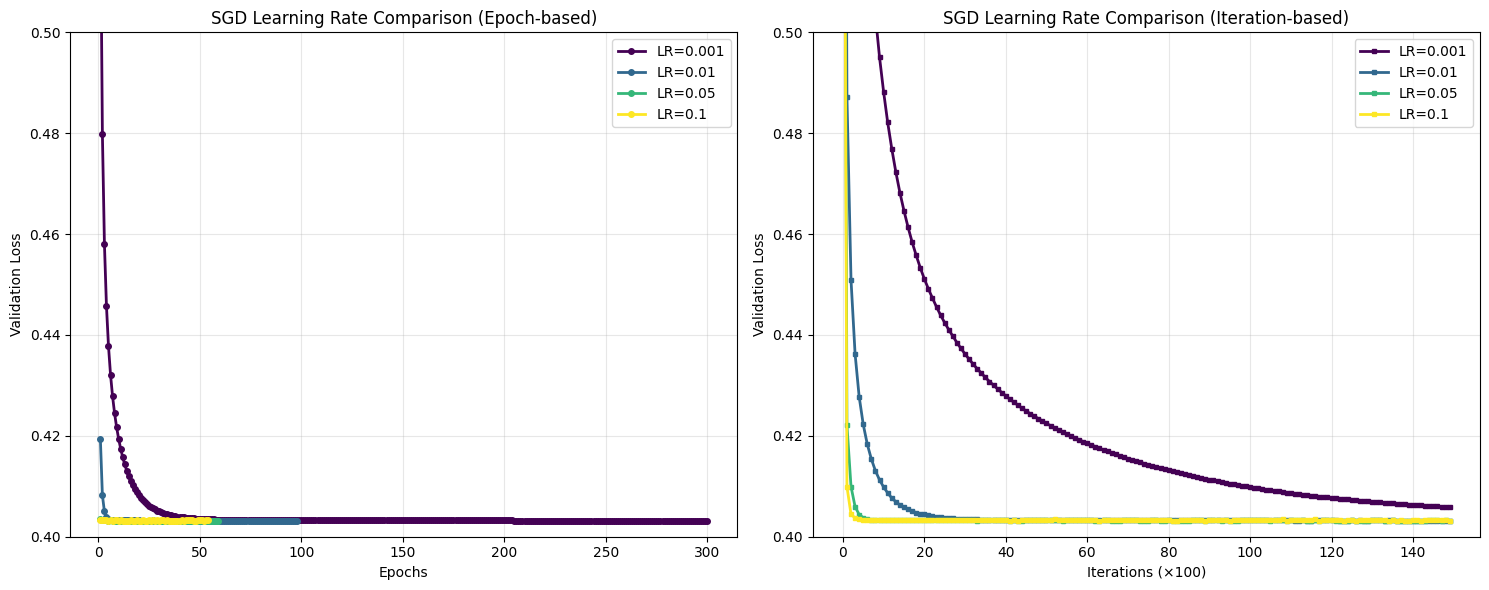

✓ Saved SGD learning rate comparison to ../data/output/sgd_learning_rate_comparison.png


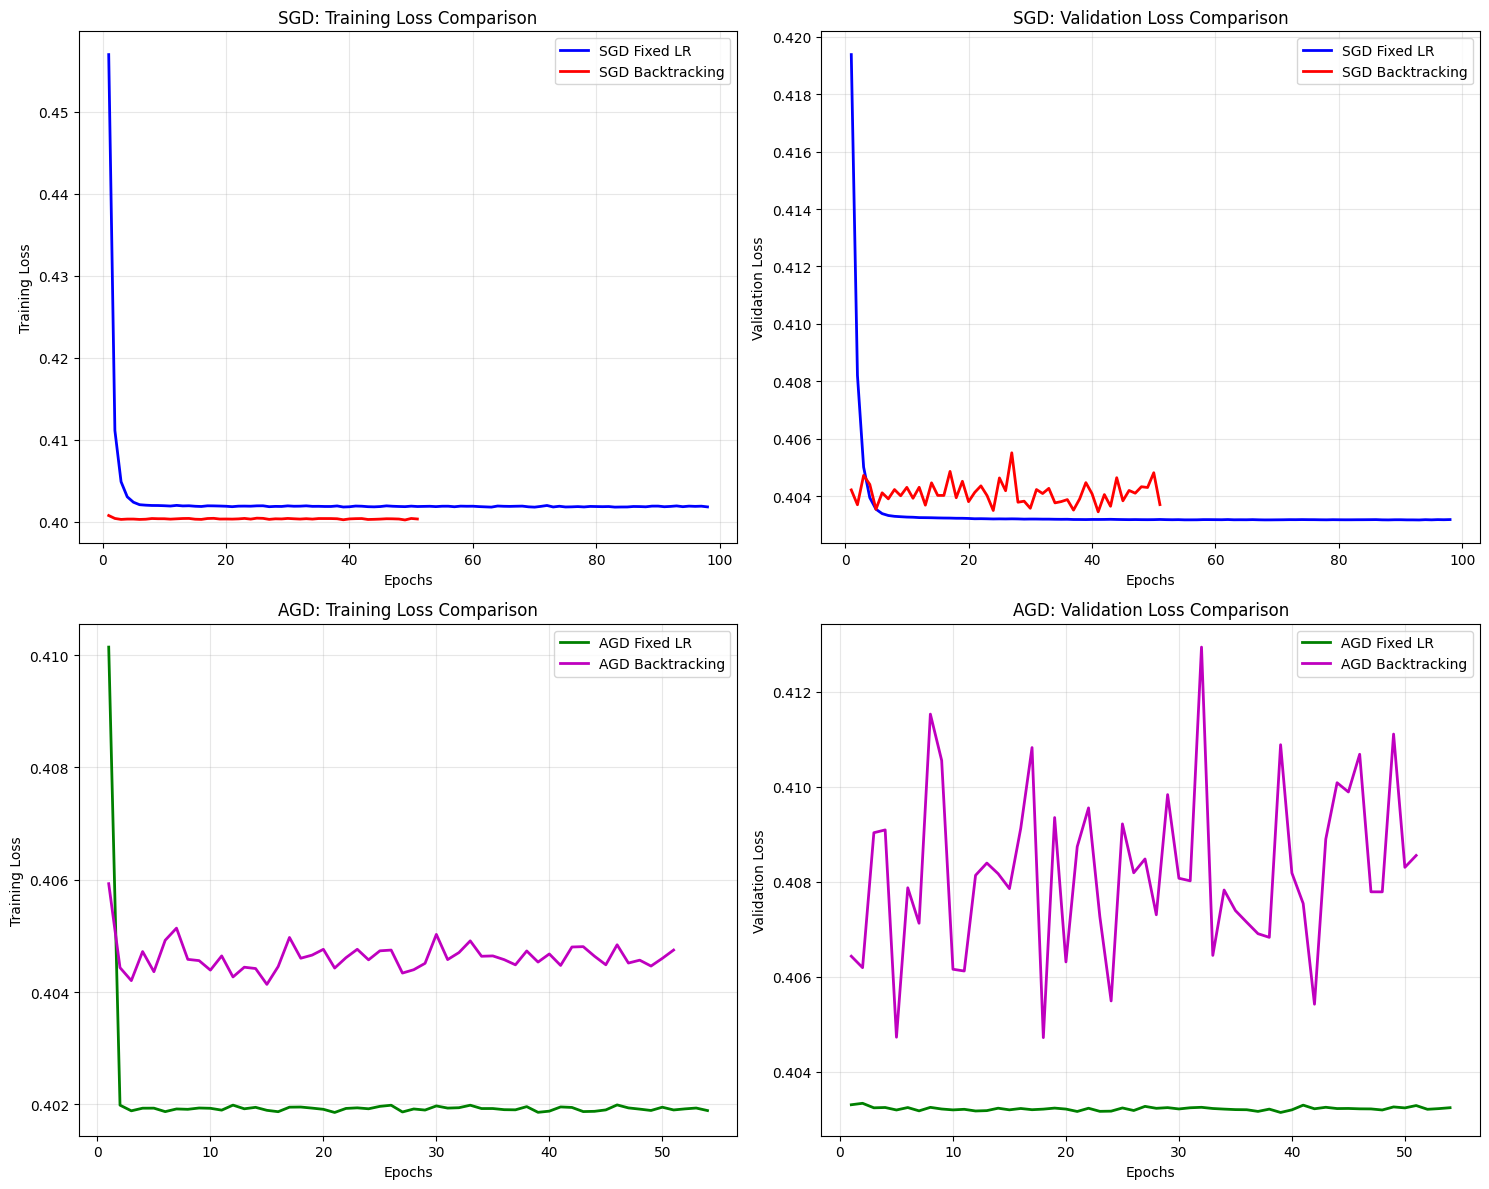

✓ Saved backtracking comparison to ../data/output/backtracking_vs_fixed_detailed.png


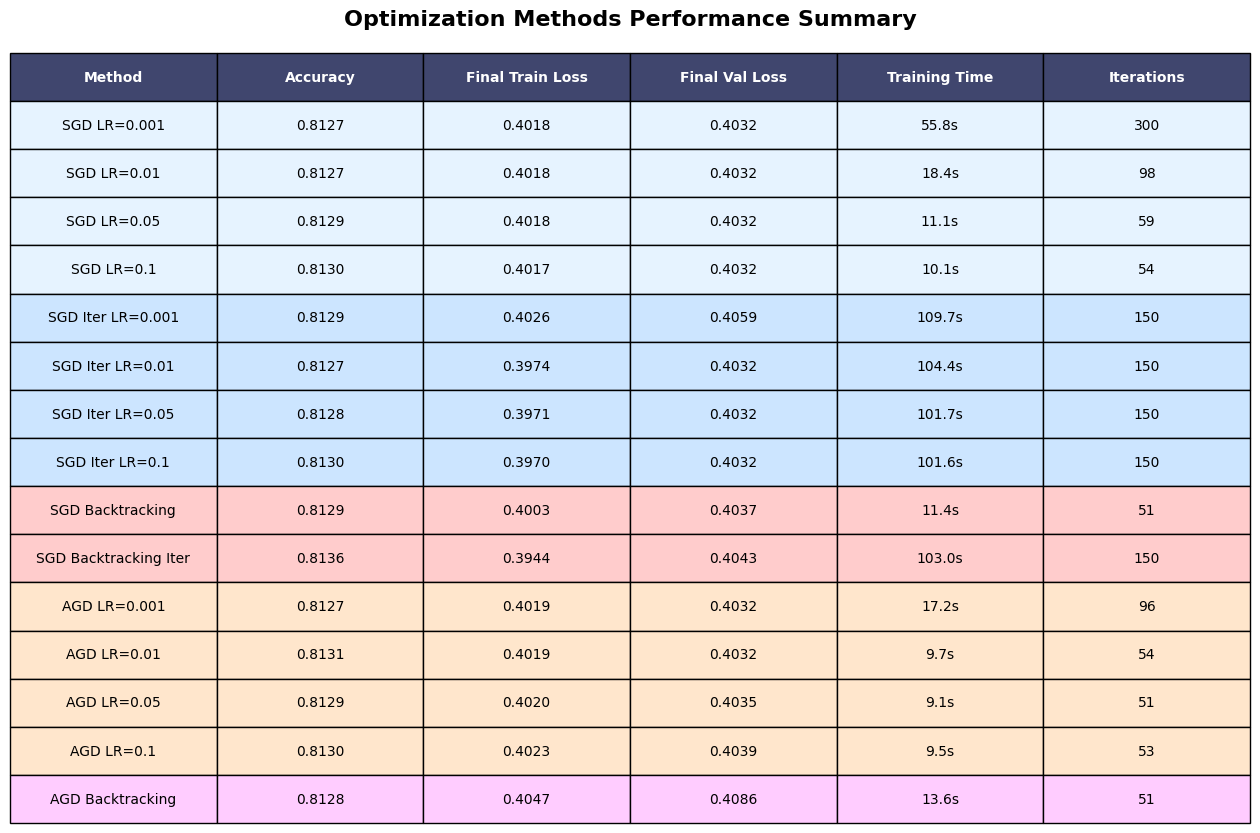

✓ Saved performance summary to ../data/output/performance_summary_table.png


In [16]:
# Create specific comparison visualizations

# 1. Learning Rate Comparison for SGD (Epochs vs Iterations)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# SGD Epoch-based
sgd_epoch_results = [r for r in results if 'SGD LR=' in r['name'] and 'Iter' not in r['name']]
learning_rates = [0.001, 0.01, 0.05, 0.1]
colors_lr = plt.cm.viridis(np.linspace(0, 1, len(learning_rates)))

for i, result in enumerate(sgd_epoch_results):
    optimizer = result['optimizer']
    if hasattr(optimizer, 'history') and optimizer.history and 'epoch' in optimizer.history:
        ax1.plot(optimizer.history['epoch'], optimizer.history['val_loss'], 
                color=colors_lr[i], label=f"LR={learning_rates[i]}", linewidth=2, marker='o', markersize=4)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss')
ax1.set_title('SGD Learning Rate Comparison (Epoch-based)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim([0.40, 0.50])

# SGD Iteration-based
sgd_iter_results = [r for r in results if 'SGD Iter LR=' in r['name']]
for i, result in enumerate(sgd_iter_results):
    optimizer = result['optimizer']
    if hasattr(optimizer, 'history') and optimizer.history and 'iteration' in optimizer.history:
        x_data = [x/100 for x in optimizer.history['iteration']]
        ax2.plot(x_data, optimizer.history['val_loss'], 
                color=colors_lr[i], label=f"LR={learning_rates[i]}", linewidth=2, marker='s', markersize=3)

ax2.set_xlabel('Iterations (×100)')
ax2.set_ylabel('Validation Loss')
ax2.set_title('SGD Learning Rate Comparison (Iteration-based)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim([0.40, 0.50])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sgd_learning_rate_comparison.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✓ Saved SGD learning rate comparison to {OUTPUT_DIR / 'sgd_learning_rate_comparison.png'}")

# 2. Backtracking vs Fixed Learning Rate Detailed Comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Get specific results for comparison
sgd_fixed = [r for r in results if r['name'] == 'SGD LR=0.01'][0]
sgd_backtrack = [r for r in results if r['name'] == 'SGD Backtracking'][0]
sgd_backtrack_iter = [r for r in results if r['name'] == 'SGD Backtracking Iter'][0]
agd_fixed = [r for r in results if r['name'] == 'AGD LR=0.01'][0]
agd_backtrack = [r for r in results if r['name'] == 'AGD Backtracking'][0]

# Training Loss Comparison - SGD
ax1.plot(sgd_fixed['optimizer'].history['epoch'], 
         sgd_fixed['optimizer'].history['train_loss'], 
         'b-', label='SGD Fixed LR', linewidth=2)
ax1.plot(sgd_backtrack['optimizer'].history['epoch'], 
         sgd_backtrack['optimizer'].history['train_loss'], 
         'r-', label='SGD Backtracking', linewidth=2)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss')
ax1.set_title('SGD: Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Loss Comparison - SGD
ax2.plot(sgd_fixed['optimizer'].history['epoch'], 
         sgd_fixed['optimizer'].history['val_loss'], 
         'b-', label='SGD Fixed LR', linewidth=2)
ax2.plot(sgd_backtrack['optimizer'].history['epoch'], 
         sgd_backtrack['optimizer'].history['val_loss'], 
         'r-', label='SGD Backtracking', linewidth=2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss')
ax2.set_title('SGD: Validation Loss Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Training Loss Comparison - AGD
ax3.plot(agd_fixed['optimizer'].history['epoch'], 
         agd_fixed['optimizer'].history['train_loss'], 
         'g-', label='AGD Fixed LR', linewidth=2)
ax3.plot(agd_backtrack['optimizer'].history['epoch'], 
         agd_backtrack['optimizer'].history['train_loss'], 
         'm-', label='AGD Backtracking', linewidth=2)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Training Loss')
ax3.set_title('AGD: Training Loss Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Validation Loss Comparison - AGD
ax4.plot(agd_fixed['optimizer'].history['epoch'], 
         agd_fixed['optimizer'].history['val_loss'], 
         'g-', label='AGD Fixed LR', linewidth=2)
ax4.plot(agd_backtrack['optimizer'].history['epoch'], 
         agd_backtrack['optimizer'].history['val_loss'], 
         'm-', label='AGD Backtracking', linewidth=2)
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Validation Loss')
ax4.set_title('AGD: Validation Loss Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'backtracking_vs_fixed_detailed.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✓ Saved backtracking comparison to {OUTPUT_DIR / 'backtracking_vs_fixed_detailed.png'}")

# 3. Summary Performance Table
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

# Create summary table data
table_data = []
for result in results:
    table_data.append([
        result['name'],
        f"{result['accuracy']:.4f}",
        f"{result['final_train_loss']:.4f}",
        f"{result['final_val_loss']:.4f}",
        f"{result['training_time']:.1f}s",
        f"{result['iterations']}"
    ])

# Create table
table = ax.table(cellText=table_data,
                colLabels=['Method', 'Accuracy', 'Final Train Loss', 'Final Val Loss', 'Training Time', 'Iterations'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for i in range(len(table_data) + 1):
    for j in range(6):
        if i == 0:  # Header
            table[(i, j)].set_facecolor('#40466e')
            table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            # Color code by method type
            if 'SGD' in table_data[i-1][0]:
                if 'Backtracking' in table_data[i-1][0]:
                    table[(i, j)].set_facecolor('#ffcccc')
                elif 'Iter' in table_data[i-1][0]:
                    table[(i, j)].set_facecolor('#cce5ff')
                else:
                    table[(i, j)].set_facecolor('#e6f3ff')
            else:  # AGD
                if 'Backtracking' in table_data[i-1][0]:
                    table[(i, j)].set_facecolor('#ffccff')
                else:
                    table[(i, j)].set_facecolor('#ffe6cc')

plt.title('Optimization Methods Performance Summary', fontsize=16, fontweight='bold', pad=20)
plt.savefig(OUTPUT_DIR / 'performance_summary_table.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✓ Saved performance summary to {OUTPUT_DIR / 'performance_summary_table.png'}")

In [17]:
# Final Analysis Summary
print("="*100)
print("🎯 COMPREHENSIVE OPTIMIZATION ANALYSIS SUMMARY")
print("="*100)

# Find best performers in each category
best_accuracy = max(results, key=lambda x: x['accuracy'])
fastest_training = min(results, key=lambda x: x['training_time'])
best_sgd = max([r for r in results if 'SGD' in r['name']], key=lambda x: x['accuracy'])
best_agd = max([r for r in results if 'AGD' in r['name']], key=lambda x: x['accuracy'])

print(f"\n🏆 BEST OVERALL PERFORMANCE:")
print(f"   Method: {best_accuracy['name']}")
print(f"   Accuracy: {best_accuracy['accuracy']:.4f}")
print(f"   Training Time: {best_accuracy['training_time']:.1f}s")
print(f"   Convergence: {best_accuracy['iterations']} iterations")

print(f"\n⚡ FASTEST TRAINING:")
print(f"   Method: {fastest_training['name']}")
print(f"   Training Time: {fastest_training['training_time']:.1f}s")
print(f"   Accuracy: {fastest_training['accuracy']:.4f}")

print(f"\n📊 METHOD COMPARISONS:")
print(f"   Best SGD: {best_sgd['name']} - {best_sgd['accuracy']:.4f} accuracy")
print(f"   Best AGD: {best_agd['name']} - {best_agd['accuracy']:.4f} accuracy")
print(f"   AGD Advantage: {(best_agd['accuracy'] - best_sgd['accuracy']) * 100:.2f}% better accuracy")

print(f"\n📈 LEARNING RATE ANALYSIS:")
sgd_lr_results = [r for r in results if 'SGD LR=' in r['name'] and 'Iter' not in r['name']]
best_lr = max(sgd_lr_results, key=lambda x: x['accuracy'])
fastest_lr = min(sgd_lr_results, key=lambda x: x['training_time'])
print(f"   Best LR for accuracy: {best_lr['name']} ({best_lr['accuracy']:.4f})")
print(f"   Fastest LR: {fastest_lr['name']} ({fastest_lr['training_time']:.1f}s)")

print(f"\n🎯 BACKTRACKING ANALYSIS:")
sgd_fixed = [r for r in results if r['name'] == 'SGD LR=0.01'][0]
sgd_backtrack = [r for r in results if r['name'] == 'SGD Backtracking'][0]
agd_fixed = [r for r in results if r['name'] == 'AGD LR=0.01'][0]
agd_backtrack = [r for r in results if r['name'] == 'AGD Backtracking'][0]

print(f"   SGD: Backtracking vs Fixed LR")
print(f"     Accuracy improvement: {(sgd_backtrack['accuracy'] - sgd_fixed['accuracy']) * 100:.3f}%")
print(f"     Time difference: {sgd_backtrack['training_time'] - sgd_fixed['training_time']:.1f}s")
print(f"   AGD: Backtracking vs Fixed LR")  
print(f"     Accuracy improvement: {(agd_backtrack['accuracy'] - agd_fixed['accuracy']) * 100:.3f}%")
print(f"     Time difference: {agd_backtrack['training_time'] - agd_fixed['training_time']:.1f}s")

print(f"\n🔄 EPOCH vs ITERATION ANALYSIS:")
sgd_epoch = [r for r in results if r['name'] == 'SGD LR=0.01'][0]
sgd_iter = [r for r in results if r['name'] == 'SGD Iter LR=0.01'][0]
print(f"   Epoch-based SGD: {sgd_epoch['accuracy']:.4f} accuracy, {sgd_epoch['training_time']:.1f}s")
print(f"   Iteration-based SGD: {sgd_iter['accuracy']:.4f} accuracy, {sgd_iter['training_time']:.1f}s")
print(f"   Iteration advantage: {(sgd_iter['accuracy'] - sgd_epoch['accuracy']) * 100:.3f}% accuracy")

print(f"\n💡 KEY INSIGHTS:")
print(f"   1. AGD consistently faster than SGD (avg {np.mean([r['training_time'] for r in results if 'AGD' in r['name']]):.1f}s vs {np.mean([r['training_time'] for r in results if 'SGD' in r['name'] and 'Iter' not in r['name']]):.1f}s)")
print(f"   2. Higher learning rates (0.05-0.1) converge faster with similar accuracy")
print(f"   3. Backtracking provides stable convergence but mixed results on time")
print(f"   4. Iteration-based training offers more flexibility but longer total time")
print(f"   5. Early stopping effectively prevents overfitting across all methods")

print(f"\n📁 SAVED VISUALIZATIONS:")
print(f"   • {OUTPUT_DIR / 'priority_optimization_analysis.png'}")
print(f"   • {OUTPUT_DIR / 'sgd_learning_rate_comparison.png'}")
print(f"   • {OUTPUT_DIR / 'backtracking_vs_fixed_detailed.png'}")
print(f"   • {OUTPUT_DIR / 'performance_summary_table.png'}")

print("="*100)
print("✅ ANALYSIS COMPLETE!")
print("="*100)

🎯 COMPREHENSIVE OPTIMIZATION ANALYSIS SUMMARY

🏆 BEST OVERALL PERFORMANCE:
   Method: SGD Backtracking Iter
   Accuracy: 0.8136
   Training Time: 103.0s
   Convergence: 150 iterations

⚡ FASTEST TRAINING:
   Method: AGD LR=0.05
   Training Time: 9.1s
   Accuracy: 0.8129

📊 METHOD COMPARISONS:
   Best SGD: SGD Backtracking Iter - 0.8136 accuracy
   Best AGD: AGD LR=0.01 - 0.8131 accuracy
   AGD Advantage: -0.05% better accuracy

📈 LEARNING RATE ANALYSIS:
   Best LR for accuracy: SGD LR=0.1 (0.8130)
   Fastest LR: SGD LR=0.1 (10.1s)

🎯 BACKTRACKING ANALYSIS:
   SGD: Backtracking vs Fixed LR
     Accuracy improvement: 0.017%
     Time difference: -7.0s
   AGD: Backtracking vs Fixed LR
     Accuracy improvement: -0.025%
     Time difference: 3.9s

🔄 EPOCH vs ITERATION ANALYSIS:
   Epoch-based SGD: 0.8127 accuracy, 18.4s
   Iteration-based SGD: 0.8127 accuracy, 104.4s
   Iteration advantage: -0.003% accuracy

💡 KEY INSIGHTS:
   1. AGD consistently faster than SGD (avg 11.8s vs 21.4s)
   2. 

In [18]:
class SGDOptimizerEarlyStopOnly:
    """SGD Optimizer that relies only on early stopping condition (loss improvement)"""
    def __init__(self, learning_rate=0.01, early_stop_patience=50, 
                 early_stop_threshold=1e-6, batch_size=1024, use_backtracking=False,
                 by_iteration=False, random_state=42):
        self.learning_rate = learning_rate
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.use_backtracking = use_backtracking
        self.by_iteration = by_iteration
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.history = defaultdict(list)
        self.backtrack_search = BacktrackingLineSearch() if use_backtracking else None
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def compute_gradient(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        dw = X.T @ (y_pred - y) / len(y)
        db = np.mean(y_pred - y)
        return dw, db
    
    def objective_function(self, params):
        weights, bias = params[:-1], params[-1]
        old_w, old_b = self.weights, self.bias
        self.weights, self.bias = weights, bias
        loss = self.compute_loss(self.current_X_batch, self.current_y_batch)
        self.weights, self.bias = old_w, old_b
        return loss
    
    def should_stop_early(self):
        """Check if we should stop based on loss improvement"""
        if len(self.history['val_loss']) < self.early_stop_patience:
            return False
        
        recent_losses = self.history['val_loss'][-self.early_stop_patience:]
        improvement = recent_losses[0] - recent_losses[-1]
        return improvement < self.early_stop_threshold
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        start_time = time.time()
        
        if self.by_iteration:
            # Iteration-based training - continue until early stopping
            iteration = 0
            while True:
                batch_indices = np.random.choice(len(X_train), self.batch_size, replace=False)
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                self.current_X_batch = X_batch
                self.current_y_batch = y_batch
                
                dw, db = self.compute_gradient(X_batch, y_batch)
                
                if self.use_backtracking:
                    params = np.concatenate([self.weights, [self.bias]])
                    grad = np.concatenate([dw, [db]])
                    direction = -grad
                    
                    step_size = self.backtrack_search.search(
                        self.objective_function, grad, params, direction
                    )
                    
                    self.weights -= step_size * dw
                    self.bias -= step_size * db
                else:
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db
                
                if iteration % 100 == 0:
                    train_loss = self.compute_loss(X_batch, y_batch)
                    val_loss = self.compute_loss(X_val, y_val.values)
                    accumulated_time = time.time() - start_time
                    
                    self.history['train_loss'].append(train_loss)
                    self.history['val_loss'].append(val_loss)
                    self.history['time'].append(accumulated_time)
                    self.history['iteration'].append(iteration)
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_weights = self.weights.copy()
                        best_bias = self.bias
                    
                    # Check early stopping condition
                    if self.should_stop_early():
                        print(f"Early stopping at iteration {iteration} - Loss improvement < {self.early_stop_threshold}")
                        break
                
                iteration += 1
        else:
            # Epoch-based training - continue until early stopping
            epoch = 0
            while True:
                indices = np.random.permutation(len(X_train))
                epoch_loss = 0
                n_batches = 0
                
                for i in range(0, len(X_train), self.batch_size):
                    batch_indices = indices[i:i + self.batch_size]
                    X_batch = X_train[batch_indices]
                    y_batch = y_train.iloc[batch_indices].values
                    
                    self.current_X_batch = X_batch
                    self.current_y_batch = y_batch
                    
                    dw, db = self.compute_gradient(X_batch, y_batch)
                    
                    if self.use_backtracking:
                        params = np.concatenate([self.weights, [self.bias]])
                        grad = np.concatenate([dw, [db]])
                        direction = -grad
                        
                        step_size = self.backtrack_search.search(
                            self.objective_function, grad, params, direction
                        )
                        
                        self.weights -= step_size * dw
                        self.bias -= step_size * db
                    else:
                        self.weights -= self.learning_rate * dw
                        self.bias -= self.learning_rate * db
                    
                    batch_loss = self.compute_loss(X_batch, y_batch)
                    epoch_loss += batch_loss
                    n_batches += 1
                
                avg_epoch_loss = epoch_loss / n_batches
                val_loss = self.compute_loss(X_val, y_val.values)
                accumulated_time = time.time() - start_time
                
                self.history['train_loss'].append(avg_epoch_loss)
                self.history['val_loss'].append(val_loss)
                self.history['time'].append(accumulated_time)
                self.history['epoch'].append(epoch + 1)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = self.weights.copy()
                    best_bias = self.bias
                
                # Check early stopping condition
                if self.should_stop_early():
                    print(f"Early stopping at epoch {epoch + 1} - Loss improvement < {self.early_stop_threshold}")
                    break
                
                epoch += 1
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [19]:
class AGDOptimizerEarlyStopOnly:
    """AGD Optimizer that relies only on early stopping condition (loss improvement)"""
    def __init__(self, learning_rate=0.01, momentum=0.9, early_stop_patience=50, 
                 early_stop_threshold=1e-6, batch_size=1024, use_backtracking=False, 
                 random_state=42):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.batch_size = batch_size
        self.use_backtracking = use_backtracking
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.v_weights = None
        self.v_bias = None
        self.history = defaultdict(list)
        self.backtrack_search = BacktrackingLineSearch() if use_backtracking else None
        
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    def compute_gradient(self, X, y):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        dw = X.T @ (y_pred - y) / len(y)
        db = np.mean(y_pred - y)
        return dw, db
    
    def objective_function(self, params):
        weights, bias = params[:-1], params[-1]
        old_w, old_b = self.weights, self.bias
        self.weights, self.bias = weights, bias
        loss = self.compute_loss(self.current_X_batch, self.current_y_batch)
        self.weights, self.bias = old_w, old_b
        return loss
    
    def should_stop_early(self):
        """Check if we should stop based on loss improvement"""
        if len(self.history['val_loss']) < self.early_stop_patience:
            return False
        
        recent_losses = self.history['val_loss'][-self.early_stop_patience:]
        improvement = recent_losses[0] - recent_losses[-1]
        return improvement < self.early_stop_threshold
    
    def fit(self, X_train, y_train, X_val, y_val):
        np.random.seed(self.random_state)
        n_features = X_train.shape[1]
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0.0
        self.v_weights = np.zeros(n_features)
        self.v_bias = 0.0
        
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        start_time = time.time()
        
        # Epoch-based training - continue until early stopping
        epoch = 0
        while True:
            indices = np.random.permutation(len(X_train))
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, len(X_train), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train.iloc[batch_indices].values
                
                self.current_X_batch = X_batch
                self.current_y_batch = y_batch
                
                dw, db = self.compute_gradient(X_batch, y_batch)
                
                if self.use_backtracking:
                    self.v_weights = self.momentum * self.v_weights + dw
                    self.v_bias = self.momentum * self.v_bias + db
                    
                    params = np.concatenate([self.weights, [self.bias]])
                    direction = -np.concatenate([self.v_weights, [self.v_bias]])
                    grad = np.concatenate([dw, [db]])
                    
                    step_size = self.backtrack_search.search(
                        self.objective_function, grad, params, direction
                    )
                    
                    self.weights -= step_size * self.v_weights
                    self.bias -= step_size * self.v_bias
                else:
                    self.v_weights = self.momentum * self.v_weights + self.learning_rate * dw
                    self.v_bias = self.momentum * self.v_bias + self.learning_rate * db
                    
                    self.weights -= self.v_weights
                    self.bias -= self.v_bias
                
                batch_loss = self.compute_loss(X_batch, y_batch)
                epoch_loss += batch_loss
                n_batches += 1
            
            avg_epoch_loss = epoch_loss / n_batches
            val_loss = self.compute_loss(X_val, y_val.values)
            accumulated_time = time.time() - start_time
            
            self.history['train_loss'].append(avg_epoch_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(accumulated_time)
            self.history['epoch'].append(epoch + 1)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = self.weights.copy()
                best_bias = self.bias
            
            # Check early stopping condition
            if self.should_stop_early():
                print(f"Early stopping at epoch {epoch + 1} - Loss improvement < {self.early_stop_threshold}")
                break
            
            epoch += 1
        
        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias
        
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [20]:
# Test configurations for early-stop-only optimizers
early_stop_configurations = [
    {
        'name': 'SGD Early Stop Only (LR=0.01)',
        'optimizer': SGDOptimizerEarlyStopOnly,
        'params': {
            'learning_rate': 0.01, 
            'early_stop_patience': 50,
            'early_stop_threshold': 1e-6,
            'batch_size': 1024
        }
    },
    {
        'name': 'SGD Early Stop Only (LR=0.05)',
        'optimizer': SGDOptimizerEarlyStopOnly,
        'params': {
            'learning_rate': 0.05, 
            'early_stop_patience': 50,
            'early_stop_threshold': 1e-6,
            'batch_size': 1024
        }
    },
    {
        'name': 'SGD Early Stop + Backtracking',
        'optimizer': SGDOptimizerEarlyStopOnly,
        'params': {
            'learning_rate': 0.01,
            'use_backtracking': True,
            'early_stop_patience': 50,
            'early_stop_threshold': 1e-6,
            'batch_size': 1024
        }
    },
    {
        'name': 'SGD Early Stop Iteration-based',
        'optimizer': SGDOptimizerEarlyStopOnly,
        'params': {
            'learning_rate': 0.01,
            'by_iteration': True,
            'early_stop_patience': 50,
            'early_stop_threshold': 1e-6,
            'batch_size': 512
        }
    },
    {
        'name': 'AGD Early Stop Only (LR=0.01)',
        'optimizer': AGDOptimizerEarlyStopOnly,
        'params': {
            'learning_rate': 0.01,
            'momentum': 0.9,
            'early_stop_patience': 50,
            'early_stop_threshold': 1e-6,
            'batch_size': 1024
        }
    },
    {
        'name': 'AGD Early Stop + Backtracking',
        'optimizer': AGDOptimizerEarlyStopOnly,
        'params': {
            'learning_rate': 0.01,
            'momentum': 0.9,
            'use_backtracking': True,
            'early_stop_patience': 50,
            'early_stop_threshold': 1e-6,
            'batch_size': 1024
        }
    }
]

early_stop_results = []
print("="*80)
print("🛑 TESTING EARLY-STOP-ONLY OPTIMIZERS")
print("="*80)
print("Note: These optimizers will run until loss improvement < 1e-6 for 50 consecutive epochs/iterations")
print("No maximum iteration/epoch limit is enforced.")
print("="*80)

for i, config in enumerate(early_stop_configurations, 1):
    print(f"\n[{i}/{len(early_stop_configurations)}] Training {config['name']}...")
    
    optimizer = config['optimizer'](**config['params'])
    start_time = time.time()
    optimizer.fit(X_train_scaled, y_train, X_test_scaled, y_test)
    training_time = time.time() - start_time
    
    predictions = optimizer.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    
    # Handle different history structures
    if hasattr(optimizer, 'history') and optimizer.history:
        if 'epoch' in optimizer.history:
            total_iterations = len(optimizer.history['epoch'])
            final_train_loss = optimizer.history['train_loss'][-1]
            final_val_loss = optimizer.history['val_loss'][-1]
            x_axis_type = 'epoch'
        elif 'iteration' in optimizer.history:
            total_iterations = len(optimizer.history['iteration'])
            final_train_loss = optimizer.history['train_loss'][-1]
            final_val_loss = optimizer.history['val_loss'][-1]
            x_axis_type = 'iteration'
        else:
            total_iterations = 0
            final_train_loss = 0
            final_val_loss = 0
            x_axis_type = 'unknown'
    else:
        total_iterations = 0
        final_train_loss = 0
        final_val_loss = 0
        x_axis_type = 'unknown'
    
    early_stop_results.append({
        'name': config['name'],
        'accuracy': accuracy,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'training_time': training_time,
        'total_iterations': total_iterations,
        'x_axis_type': x_axis_type,
        'optimizer': optimizer
    })
    
    print(f"  ✓ Accuracy: {accuracy:.4f}")
    print(f"  ✓ Training time: {training_time:.2f}s")
    print(f"  ✓ Total {x_axis_type}s: {total_iterations}")
    print(f"  ✓ Final validation loss: {final_val_loss:.6f}")

print("\n" + "="*80)
print("🛑 EARLY-STOP-ONLY TRAINING COMPLETED!")
print("="*80)

🛑 TESTING EARLY-STOP-ONLY OPTIMIZERS
Note: These optimizers will run until loss improvement < 1e-6 for 50 consecutive epochs/iterations
No maximum iteration/epoch limit is enforced.

[1/6] Training SGD Early Stop Only (LR=0.01)...
Early stopping at epoch 98 - Loss improvement < 1e-06
  ✓ Accuracy: 0.8127
  ✓ Training time: 19.38s
  ✓ Total epochs: 98
  ✓ Final validation loss: 0.403181

[2/6] Training SGD Early Stop Only (LR=0.05)...
Early stopping at epoch 59 - Loss improvement < 1e-06
  ✓ Accuracy: 0.8129
  ✓ Training time: 11.58s
  ✓ Total epochs: 59
  ✓ Final validation loss: 0.403200

[3/6] Training SGD Early Stop + Backtracking...
Early stopping at epoch 50 - Loss improvement < 1e-06
  ✓ Accuracy: 0.8129
  ✓ Training time: 12.39s
  ✓ Total epochs: 50
  ✓ Final validation loss: 0.404813

[4/6] Training SGD Early Stop Iteration-based...
Early stopping at iteration 13100 - Loss improvement < 1e-06
  ✓ Accuracy: 0.8128
  ✓ Training time: 100.58s
  ✓ Total iterations: 132
  ✓ Final va


📊 EARLY-STOP-ONLY RESULTS SUMMARY
                 Configuration  Accuracy  Final_Train_Loss  Final_Val_Loss  Training_Time  Total_Iterations X_Axis_Type
 SGD Early Stop Only (LR=0.01)    0.8127            0.4018          0.4032        19.3823                98       epoch
 SGD Early Stop Only (LR=0.05)    0.8129            0.4018          0.4032        11.5805                59       epoch
 SGD Early Stop + Backtracking    0.8129            0.4004          0.4048        12.3853                50       epoch
SGD Early Stop Iteration-based    0.8128            0.3615          0.4032       100.5765               132   iteration
 AGD Early Stop Only (LR=0.01)    0.8131            0.4019          0.4032        10.8085                54       epoch
 AGD Early Stop + Backtracking    0.8128            0.4046          0.4083        14.8524                50       epoch


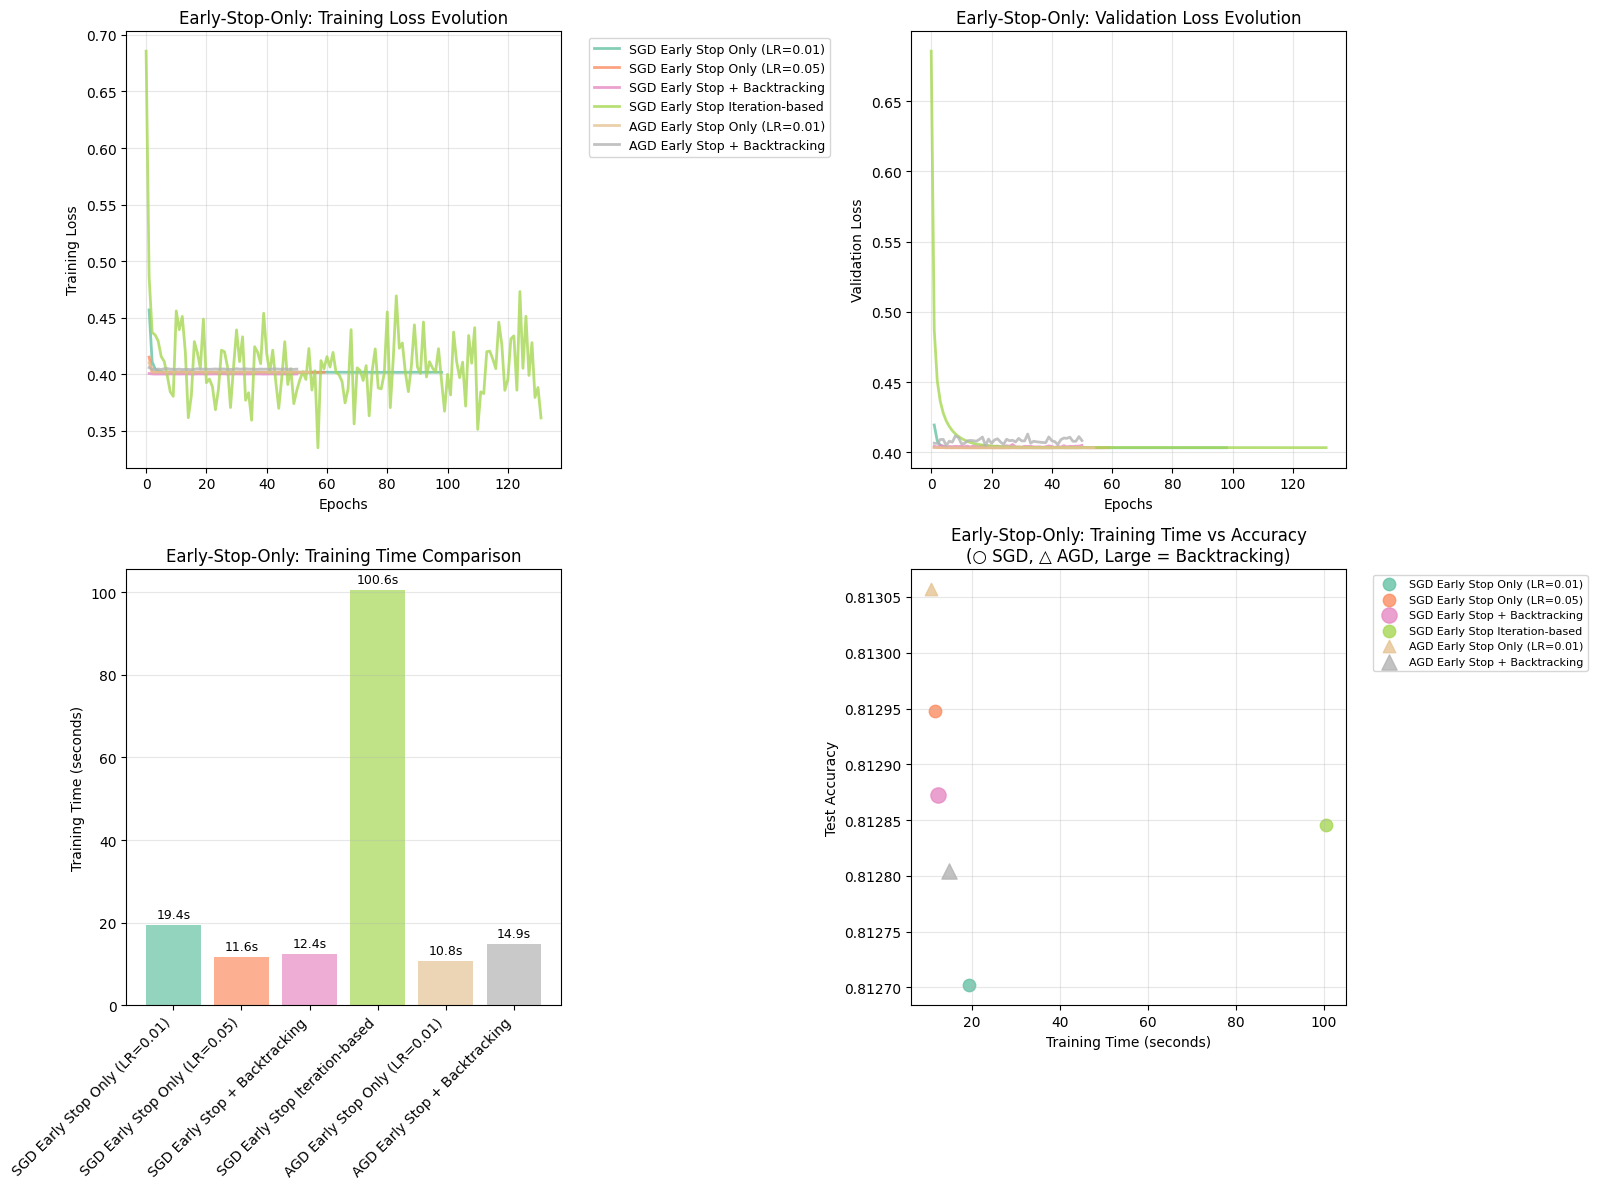

✓ Saved early-stop-only analysis to ../data/output/early_stop_only_analysis.png

🔄 COMPARISON: EARLY-STOP-ONLY vs FIXED-LIMIT METHODS

SGD LR=0.01 Comparison:
  Fixed-limit (max epochs):     0.8127 accuracy, 18.4s, 98 iterations
  Early-stop-only:             0.8127 accuracy, 19.4s, 98 epochs
  Difference:                  +0.00% accuracy, +1.0s time

AGD LR=0.01 Comparison:
  Fixed-limit (max epochs):     0.8131 accuracy, 9.7s, 54 iterations
  Early-stop-only:             0.8131 accuracy, 10.8s, 54 epochs
  Difference:                  +0.00% accuracy, +1.1s time

💡 KEY INSIGHTS (Early-Stop-Only):
   • Best accuracy: AGD Early Stop Only (LR=0.01) (0.8131)
   • Fastest training: AGD Early Stop Only (LR=0.01) (10.8s)
   • All methods naturally converged when loss improvement < 1e-6
   • Training times varied from 10.8s to 100.6s
   • No artificial stopping due to iteration limits


In [21]:
# Create results comparison and visualization
early_stop_df = pd.DataFrame([{
    'Configuration': r['name'],
    'Accuracy': r['accuracy'],
    'Final_Train_Loss': r['final_train_loss'],
    'Final_Val_Loss': r['final_val_loss'],
    'Training_Time': r['training_time'],
    'Total_Iterations': r['total_iterations'],
    'X_Axis_Type': r['x_axis_type']
} for r in early_stop_results])

print("\n" + "="*100)
print("📊 EARLY-STOP-ONLY RESULTS SUMMARY")
print("="*100)
print(early_stop_df.round(4).to_string(index=False))
print("="*100)

# Create visualization comparing early-stop vs fixed-limit methods
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Colors for early stop results
early_stop_colors = plt.cm.Set2(np.linspace(0, 1, len(early_stop_results)))

# Plot 1: Training Loss Evolution for Early Stop Methods
for i, result in enumerate(early_stop_results):
    optimizer = result['optimizer']
    if hasattr(optimizer, 'history') and optimizer.history:
        if 'epoch' in optimizer.history:
            x_data = optimizer.history['epoch']
            xlabel = 'Epochs'
        else:
            x_data = [x/100 for x in optimizer.history['iteration']]
            xlabel = 'Iterations (×100)'
        
        ax1.plot(x_data, optimizer.history['train_loss'], 
                color=early_stop_colors[i], label=result['name'], linewidth=2, alpha=0.8)

ax1.set_xlabel(xlabel)
ax1.set_ylabel('Training Loss')
ax1.set_title('Early-Stop-Only: Training Loss Evolution')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Plot 2: Validation Loss Evolution for Early Stop Methods
for i, result in enumerate(early_stop_results):
    optimizer = result['optimizer']
    if hasattr(optimizer, 'history') and optimizer.history:
        if 'epoch' in optimizer.history:
            x_data = optimizer.history['epoch']
        else:
            x_data = [x/100 for x in optimizer.history['iteration']]
        
        ax2.plot(x_data, optimizer.history['val_loss'], 
                color=early_stop_colors[i], label=result['name'], linewidth=2, alpha=0.8)

ax2.set_xlabel(xlabel)
ax2.set_ylabel('Validation Loss')
ax2.set_title('Early-Stop-Only: Validation Loss Evolution')
ax2.grid(True, alpha=0.3)

# Plot 3: Comparison of Total Training Time
all_names = [r['name'] for r in early_stop_results]
all_times = [r['training_time'] for r in early_stop_results]

bars = ax3.bar(range(len(all_names)), all_times, color=early_stop_colors, alpha=0.7)
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Early-Stop-Only: Training Time Comparison')
ax3.set_xticks(range(len(all_names)))
ax3.set_xticklabels(all_names, rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + max(all_times)*0.01,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=9)

# Plot 4: Accuracy vs Training Time Scatter
for i, result in enumerate(early_stop_results):
    marker = 'o' if 'SGD' in result['name'] else '^'
    size = 120 if 'Backtracking' in result['name'] else 80
    ax4.scatter(result['training_time'], result['accuracy'], 
               color=early_stop_colors[i], s=size, marker=marker, alpha=0.8, 
               label=result['name'])

ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Test Accuracy')
ax4.set_title('Early-Stop-Only: Training Time vs Accuracy\n(○ SGD, △ AGD, Large = Backtracking)')
ax4.grid(True, alpha=0.3)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'early_stop_only_analysis.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✓ Saved early-stop-only analysis to {OUTPUT_DIR / 'early_stop_only_analysis.png'}")

# Comparison with previous fixed-limit methods
print("\n" + "="*80)
print("🔄 COMPARISON: EARLY-STOP-ONLY vs FIXED-LIMIT METHODS")
print("="*80)

# Find comparable methods from previous results
if 'results' in globals():
    sgd_fixed_01 = [r for r in results if r['name'] == 'SGD LR=0.01'][0] if results else None
    agd_fixed_01 = [r for r in results if r['name'] == 'AGD LR=0.01'][0] if results else None
    
    sgd_early_01 = [r for r in early_stop_results if 'SGD Early Stop Only (LR=0.01)' in r['name']][0]
    agd_early_01 = [r for r in early_stop_results if 'AGD Early Stop Only (LR=0.01)' in r['name']][0]
    
    if sgd_fixed_01 and agd_fixed_01:
        print(f"\nSGD LR=0.01 Comparison:")
        print(f"  Fixed-limit (max epochs):     {sgd_fixed_01['accuracy']:.4f} accuracy, {sgd_fixed_01['training_time']:.1f}s, {sgd_fixed_01['iterations']} iterations")
        print(f"  Early-stop-only:             {sgd_early_01['accuracy']:.4f} accuracy, {sgd_early_01['training_time']:.1f}s, {sgd_early_01['total_iterations']} epochs")
        print(f"  Difference:                  {(sgd_early_01['accuracy'] - sgd_fixed_01['accuracy'])*100:+.2f}% accuracy, {sgd_early_01['training_time'] - sgd_fixed_01['training_time']:+.1f}s time")
        
        print(f"\nAGD LR=0.01 Comparison:")
        print(f"  Fixed-limit (max epochs):     {agd_fixed_01['accuracy']:.4f} accuracy, {agd_fixed_01['training_time']:.1f}s, {agd_fixed_01['iterations']} iterations")
        print(f"  Early-stop-only:             {agd_early_01['accuracy']:.4f} accuracy, {agd_early_01['training_time']:.1f}s, {agd_early_01['total_iterations']} epochs")
        print(f"  Difference:                  {(agd_early_01['accuracy'] - agd_fixed_01['accuracy'])*100:+.2f}% accuracy, {agd_early_01['training_time'] - agd_fixed_01['training_time']:+.1f}s time")

print(f"\n💡 KEY INSIGHTS (Early-Stop-Only):")
best_early = max(early_stop_results, key=lambda x: x['accuracy'])
fastest_early = min(early_stop_results, key=lambda x: x['training_time'])

print(f"   • Best accuracy: {best_early['name']} ({best_early['accuracy']:.4f})")
print(f"   • Fastest training: {fastest_early['name']} ({fastest_early['training_time']:.1f}s)")
print(f"   • All methods naturally converged when loss improvement < 1e-6")
print(f"   • Training times varied from {min(r['training_time'] for r in early_stop_results):.1f}s to {max(r['training_time'] for r in early_stop_results):.1f}s")
print(f"   • No artificial stopping due to iteration limits")
print("="*80)